In [1]:
# Dataset de 23.6 MB
import gdown
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin

file_id = '1yY7QtyB3UP8ToKZ0CUDFrDXCZRmdJnll'
dataset_url = f'https://drive.google.com/uc?id={file_id}'
dataset_path = 'data/Loan_default.csv'

os.makedirs(os.path.dirname(dataset_path), exist_ok=True)

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    gdown.download(dataset_url, dataset_path, quiet=False)
    print("Dataset downloaded and saved to", dataset_path)
else:
    print("Dataset already exists")

df = pd.read_csv(dataset_path)

Dataset already exists


# 1. Listado de variables y selección

In [2]:
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


<table>
    <tr>
        <td><strong>Variable</strong></td>
        <td><strong>Definición</strong></td>
        <td style="text-align: center;"><strong>Variable de entrada</strong></td>
        <td><strong>Clave</strong></td>
    </tr>
    <tr>
        <td>LoanID</td>
        <td>Identificador único del préstamo</td>
        <td style="text-align: center;">No</td>
        <td></td>
    </tr>
    <tr>
        <td>Age</td>
        <td>Edad en años</td>
        <td style="text-align: center;">Sí</td>
        <td></td>
    </tr>
    <tr>
        <td>Income</td>
        <td>Ingreso anual de la persona</td>
        <td style="text-align: center;">Sí</td>
        <td></td>
    </tr>
    <tr>
        <td>LoanAmount</td>
        <td>Monto total</td>
        <td style="text-align: center;">Sí</td>
        <td></td>
    </tr>
    <tr>
        <td>CreditScore</td>
        <td>Puntaje de crédito</td>
        <td style="text-align: center;">Sí</td>
        <td></td>
    </tr>
    <tr>
        <td>MonthsEmployed</td>
        <td>Número de meses que la persona ha estado empleado</td>
        <td style="text-align: center;">Sí</td>
        <td></td>
    </tr>
    <tr>
        <td>NumCreditLines</td>
        <td>Número de líneas de crédito abiertas</td>
        <td style="text-align: center;">Sí</td>
        <td></td>
    </tr>
    <tr>
        <td>InterestRate</td>
        <td>Tasa de interés a pagar</td>
        <td style="text-align: center;">Sí</td>
        <td></td>
    </tr>
    <tr>
        <td>LoanTerm</td>
        <td>Duración en meses</td>
        <td style="text-align: center;">Sí</td>
        <td></td>
    </tr>
    <tr>
        <td>DTIRatio</td>
        <td>Relación deuda-ingreso de la persona</td>
        <td style="text-align: center;">Sí</td>
        <td></td>
    </tr>
    <tr>
        <td>Education</td>
        <td>Nivel educativo</td>
        <td style="text-align: center;">Sí</td>
        <td></td>
    </tr>
    <tr>
        <td>EmploymentType</td>
        <td>Tipo de empleo</td>
        <td style="text-align: center;">Sí</td>
        <td></td>
    </tr>
    <tr>
        <td>MaritalStatus</td>
        <td>Estado civil</td>
        <td style="text-align: center;">Sí</td>
        <td></td>
    </tr>
    <tr>
        <td>HasMortgage</td>
        <td>Indica si tiene una hipoteca</td>
        <td style="text-align: center;">Sí</td>
        <td>0 = No, 1 = Sí</td>
    </tr>
    <tr>
        <td>HasDependents</td>
        <td>Indica si tiene otras personas a cargo</td>
        <td style="text-align: center;">Sí</td>
        <td>0 = No, 1 = Sí</td>
    </tr>
    <tr>
        <td>LoanPurpose</td>
        <td>Propósito del préstamo</td>
        <td style="text-align: center;">Sí</td>
        <td></td>
    </tr>
    <tr>
        <td>HasCoSigner</td>
        <td>Indica si el préstamo tiene un garante</td>
        <td style="text-align: center;">Sí</td>
        <td>0 = No, 1 = Sí</td>
    </tr>
    <tr>
        <td>Default</td>
        <td>Indica si el préstamo fue incumplido</td>
        <td style="text-align: center;">No</td>
        <td>0 = No, 1 = Sí</td>
    </tr>
</table>


1- **LoanID** es un identificador único del préstamo y no se utilizará en el análisis (es sólo un identificador, no aporta información para predecir un incumplimiento del préstamo).

2- **Age** representa la edad de la persona que quiere obtener el préstamo, en años y se utilizará como variable de entrada. Podría influir en la probabilidad de incumplimiento (menor edad, más chances de que ante un incumplimiento se logre cobrar igual el préstamo y mayor edad, más chances de que la persona se transforme en moroso incobrable).

3- **Income** es el ingreso anual del de la persona que quiere obtener el préstamo y se utilizará como variable de entrada, porque es un factor importante para evaluar la capacidad de pago.

4- **LoanAmount** monto total del préstamo y se utilizará como variable de entrada. Es una variable muy importante en el análisis de predicción de incumplimiento (refleja la cantidad de dinero en la cual la persona se endeuda).

5- **CreditScore** es el puntaje de crédito de la persona y se utilizará como variable de entrada porque es un indicador clave del comportamiento financiero pasado y de la probabilidad de incumplimiento.

6- **MonthsEmployed** indica los meses que la persona ha estado empleado y se utilizará como variable de entrada, ya que la estabilidad laboral puede ser un factor determinante en la capacidad de pago del préstamo y también la capacidad de ahorro.

7- **NumCreditLines** es el número de líneas de crédito abiertas y se utilizará como variable de entrada porque indica la experiencia y el manejo del crédito por parte de la persona, por otra parte, también ayuda a saber el nivel de endeudamiento actual y si podrá ser capaz de afrontar todas las deudas.

8- **InterestRate** es la tasa de interés del préstamo y se utilizará como variable de entrada, ya que una tasa alta podría aumentar el riesgo de incumplimiento y también influye sobre el capital total a devolver.

9- **LoanTerm** es la duración del préstamo en meses y se utilizará como variable de entrada, ya que un plazo más largo puede reducir el monto de los pagos mensuales, lo cual facilita el cumplimiento de las cuotas del préstamo (menor monto). Sin embargo, también puede aumentar el costo total del préstamo debido a los intereses acumulados.

10- **DTIRatio** es la relación deuda-ingreso de la persona y se utilizará como variable de entrada, ya que es un indicador directo de la carga de deuda respecto a sus ingresos.

11- **Education** describe el nivel educativo de la persona y se utilizará como variable de entrada, ya que puede influir en las oportunidades de empleo y la estabilidad financiera.

12- **EmploymentType** indica el tipo de empleo de la persona, como a tiempo completo o parcial, y se utilizará como variable de entrada porque puede afectar la estabilidad del ingreso de la persona.

13- **MaritalStatus** es el estado civil de la persona y se utilizará como variable de entrada, ya que puede influir en la situación financiera y las responsabilidades económicas.

14- **HasMortgage** señala si la persona tiene una hipoteca y se utilizará como variable de entrada, porque tener una hipoteca (que es una deuda existente), puede afectar la capacidad de asumir más deuda.

15- **HasDependents** indica si la persona tiene personas a cargo y se utilizará como variable de entrada, ya que tener otras personas a cargo puede aumentar las obligaciones financieras.

16- **LoanPurpose** describe el propósito del préstamo y se utilizará como variable de entrada porque podría influir en el riesgo asociado al mismo.

17- **HasCoSigner** muestra si el préstamo tiene un garante y se utilizará como variable de entrada. Un garante puede reducir el riesgo de incumplimiento al compartir la responsabilidad del préstamo.

18- **Default** indica si la persona incumplió el préstamo y se utilizará como variable de salida. Es la variable objetivo que se busca predecir, con posibles valores de 0 (no incumplido) y 1 (incumplido).

# 2. Análisis detallado de un conjunto de variables

Explicación variable de salida: una variable binaria con dos valores posibles: 0 y 1. 

El dataset está fuertemente desbalanceado, por lo tanto, la variable de salida también, con la mayoría de los préstamos en la clase 0 (sin incumplimiento). Solo alrededor de un 11% de los préstamos están en la clase 1 (incumplimiento).

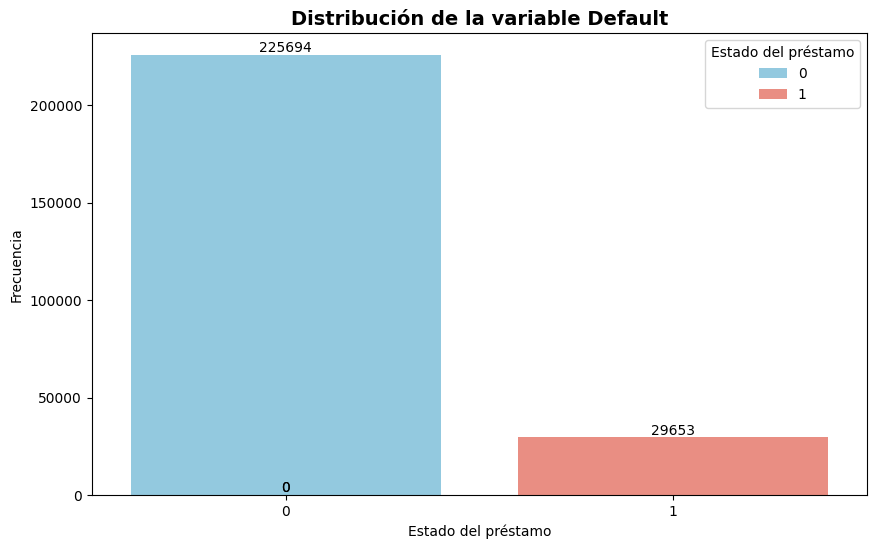

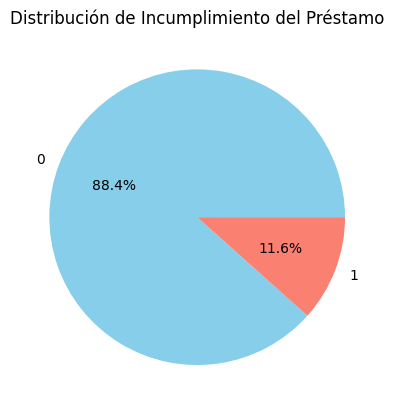

In [2]:
default_counts = df['Default'].value_counts()

data = pd.DataFrame({
    'Estado del préstamo': default_counts.index,
    'Frecuencia': default_counts.values
})

color_palette = {0: 'skyblue', 1: 'salmon'}
plt.figure(figsize=(10, 6))

ax = sns.barplot(x='Estado del préstamo', y='Frecuencia', data=data, palette=color_palette, hue='Estado del préstamo', errorbar=None)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Distribución de la variable Default', fontsize=14, weight='bold')
plt.show()

# Gráfico de pastel
default_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Distribución de Incumplimiento del Préstamo')
plt.ylabel('')
plt.show()

# Comparación entre cada variable de entrada que utilizaremos y la variable de salida.

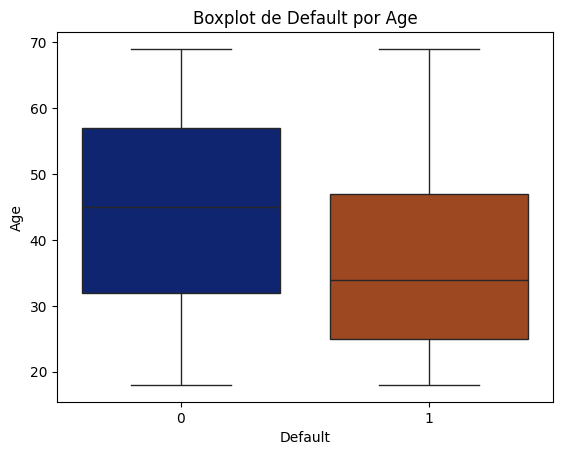

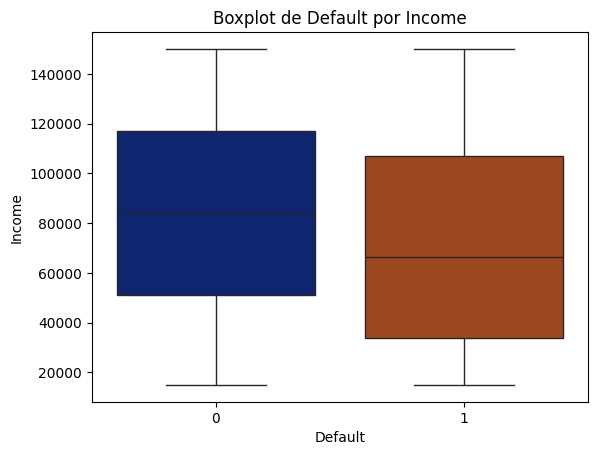

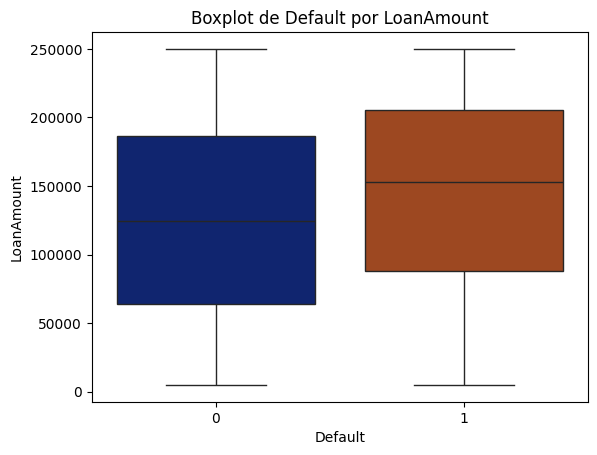

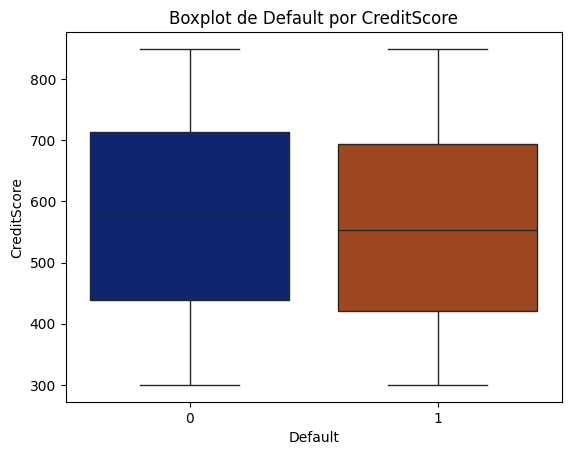

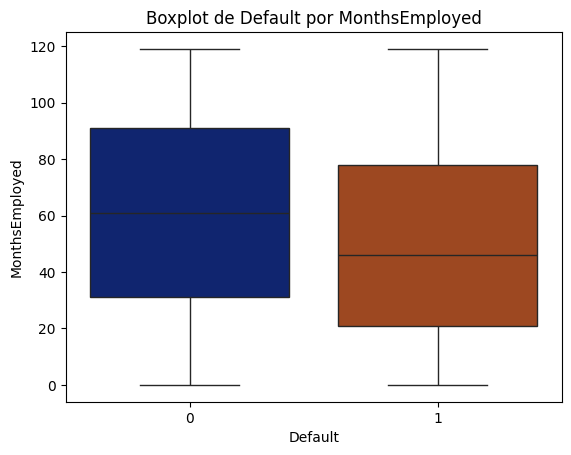

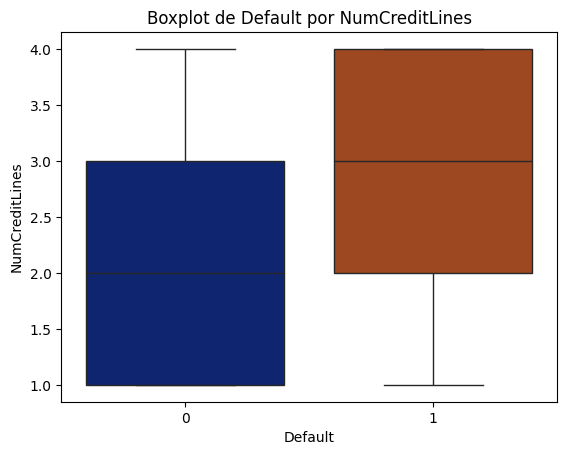

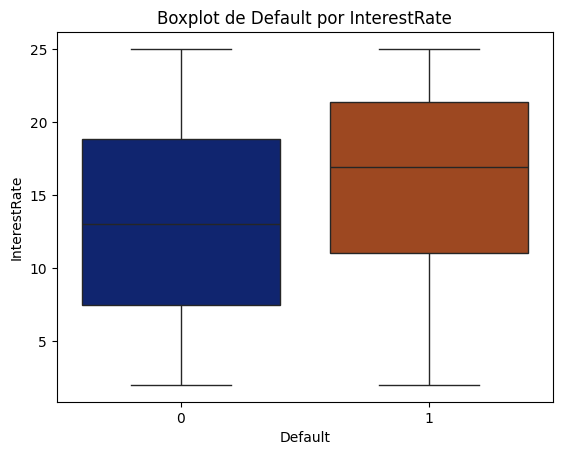

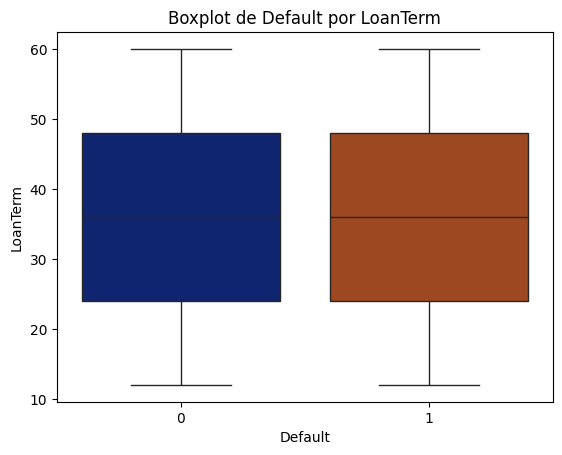

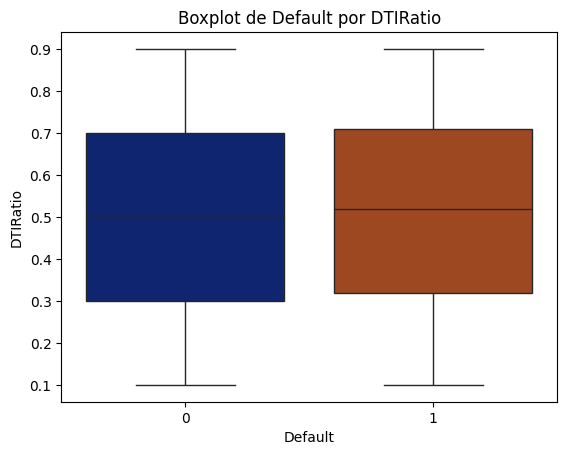

In [35]:
df_num = df.select_dtypes(exclude = ['object'])
df_num_show = df_num

if 'Default' in df_num_show.columns:
    df_num_show = df_num_show.drop(columns=['Default'])

for col in df_num_show:
    sns.boxplot(x='Default', y=df[col], data=df, hue='Default', palette='dark', legend=False)
    plt.title(f'Boxplot de Default por {col}')
    plt.show()

# Distribucion variables de entrada

**Variable:** Age  

**Distribución de los datos:** distribución relativamente uniforme entre las edades de 18 a 69 años. Las edades más frecuentes se encuentran en el rango de 33 a 40 años, con el valor más alto en 40 años (5056).

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:**  Las personas más jóvenes parecen tener una mayor tasa de incumplimiento de préstamos, ya que el rango de edades en los incumplidores está más hacia el rango más joven. A medida que la edad aumenta, la probabilidad de incumplimiento parece disminuir, como lo sugiere el hecho de que la mayor parte del grupo sin incumplimiento está compuesto por personas mayores.

**Transformación:** Normalizar, para que esté en un rango común con las demás variables.  

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

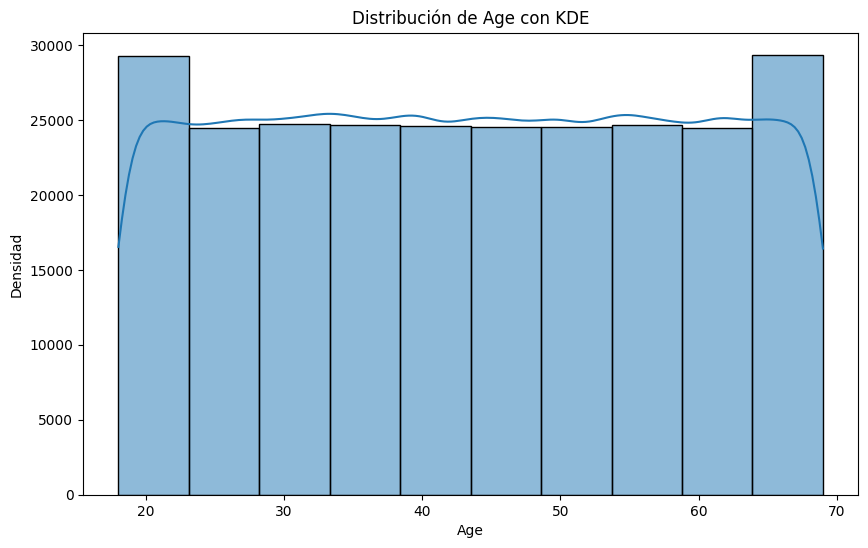

<Axes: >

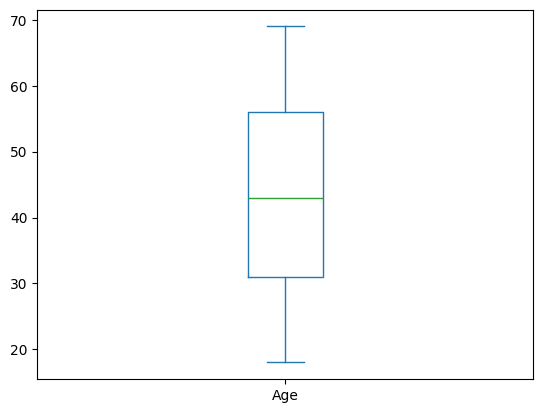

In [36]:
# Distribución de 'Age'
age = df['Age'].value_counts()

# Convertir a DataFrame
age_df = pd.DataFrame(list(age.items()), columns=['Age', 'Count'])

# Graficar en formato de histograma
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=10, kde=True)
plt.title('Distribución de Age con KDE')
plt.xlabel('Age')
plt.ylabel('Densidad')
plt.show()

# Boxplot de 'Age'
df['Age'].plot.box()

**Variable:** Income  

**Distribución de los datos:** distribución uniforme entre ingresos de 15000 a 14999.

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** las personas con un ingreso más bajo tienden a tener un mayor riesgo de incumplimiento.

**Transformación:** Normalizar.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

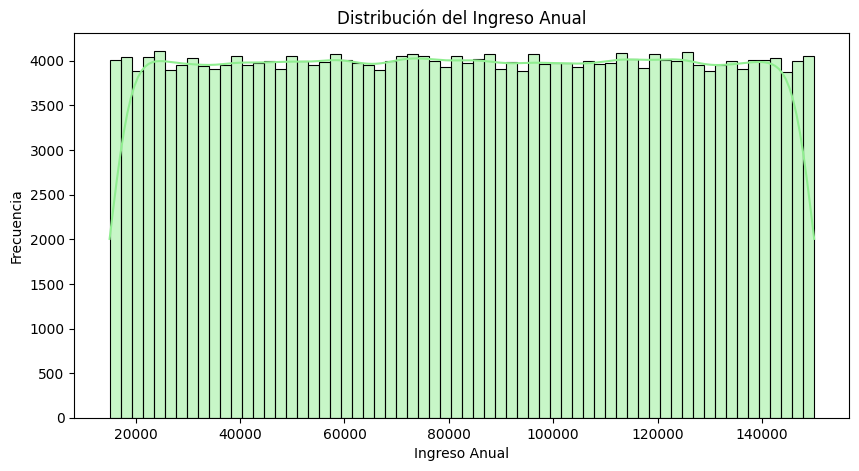

<Axes: >

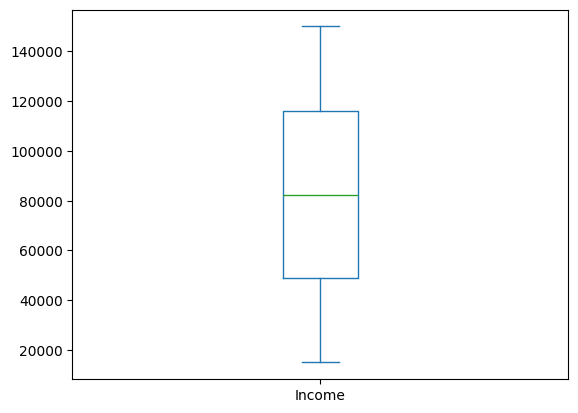

In [37]:
# Income (Ingreso Anual)
Income = df['Income'].value_counts()

# Histograma de la variable 'Income'
plt.figure(figsize=(10, 5))
sns.histplot(df['Income'], kde=True, color='lightgreen')
plt.title('Distribución del Ingreso Anual')
plt.xlabel('Ingreso Anual')
plt.ylabel('Frecuencia')
plt.show()
# Boxplot de la variable 'Income'
df['Income'].plot.box()

**Variable:** CreditScore  

**Distribución de los datos:** distribución uniforme entre credit score de 300 a 849.

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** un puntaje de crédito más bajo está ligeramente asociado con un mayor riesgo de incumplimiento, pero la relación no es fuerte.

**Transformación:** Normalizar.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles y algunas prácticamente nulas (por ejemplo con NumCreditLines).

CreditScore
300    484
301    460
302    451
303    489
304    456
      ... 
845    438
846    437
847    450
848    463
849    496
Name: count, Length: 550, dtype: int64


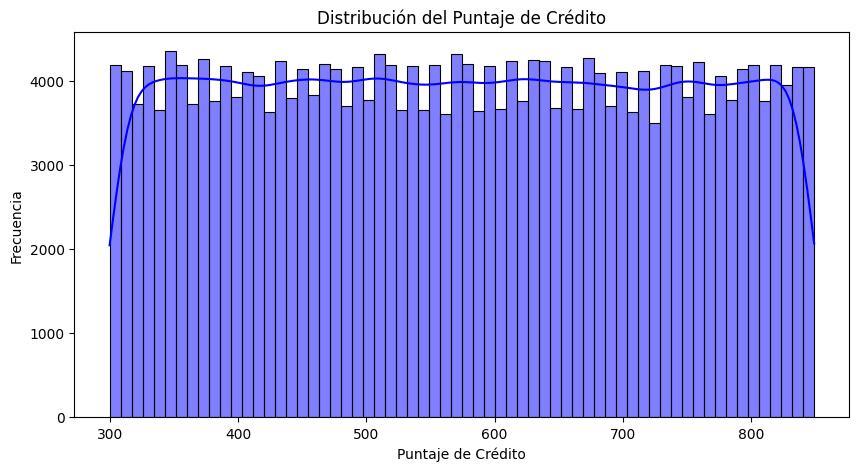

In [38]:
# CreditScore (Puntaje de Crédito)
CreditScore = df['CreditScore'].value_counts()
print(CreditScore.sort_index())

# Histograma de la variable 'CreditScore'
plt.figure(figsize=(10, 5))
sns.histplot(df['CreditScore'], kde=True, color='blue')
plt.title('Distribución del Puntaje de Crédito')
plt.xlabel('Puntaje de Crédito')
plt.ylabel('Frecuencia')
plt.show()

**Variable:** LoanAmount  

**Distribución de los datos:** distribución uniforme entre monto del préstamo de 5000 a 249999.

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** en general, los préstamos de mayor monto podrían están algo asociados con un mayor riesgo de incumplimiento.

**Transformación:** Normalizar.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles y algunas prácticamente nulas (por ejemplo con HasDependents y LoanPurpose).

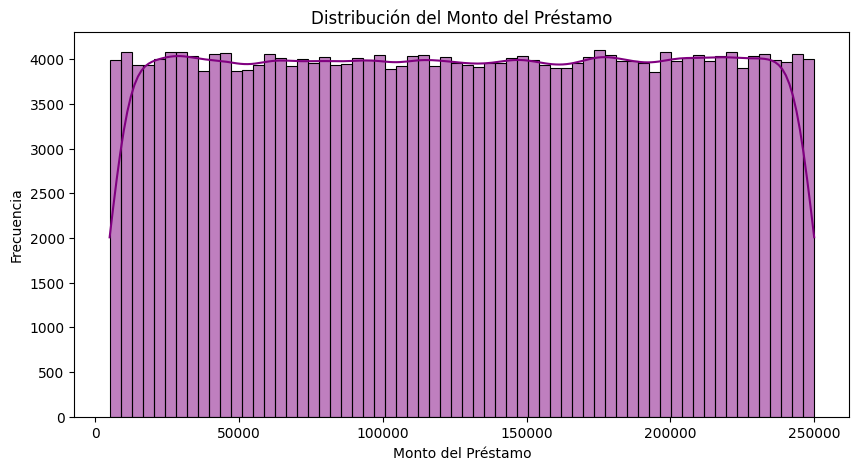

In [39]:
# LoanAmount (Monto del Préstamo)
LoanAmount = df['LoanAmount'].value_counts()

# Histograma de la variable 'LoanAmount'
plt.figure(figsize=(10, 5))
sns.histplot(df['LoanAmount'], kde=True, color='purple')
plt.title('Distribución del Monto del Préstamo')
plt.xlabel('Monto del Préstamo')
plt.ylabel('Frecuencia')
plt.show()

**Variable:** DTIRatio  

**Distribución de los datos:** distribución uniforme (con picos -> ver de poner bien a que distribucion ajusta), entre DTIRatio de 0.1 a 0.9.

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** un mayor DTIRatio puede estar asociado con un mayor riesgo de incumplimiento, aunque la relación es bastante débil.

**Transformación:** no es neceasario, va entre 0 y 1.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

DTIRatio
0.10    1611
0.11    3051
0.12    3224
0.13    3285
0.14    3228
        ... 
0.86    3274
0.87    3152
0.88    3168
0.89    3134
0.90    1605
Name: count, Length: 81, dtype: int64


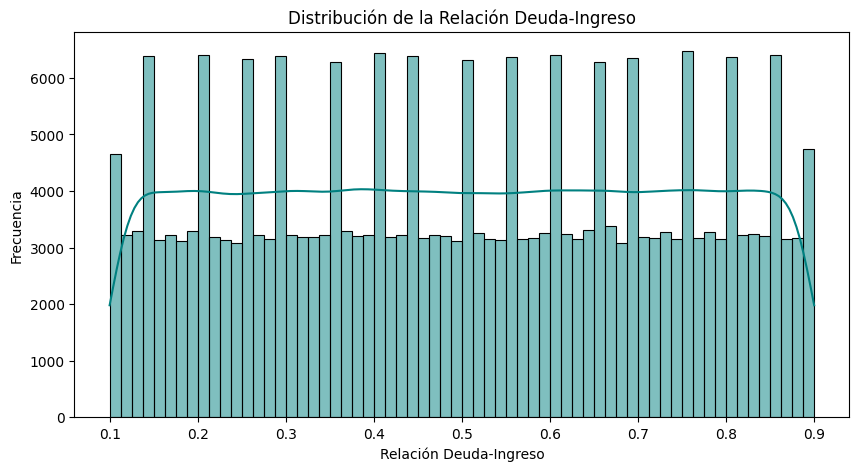

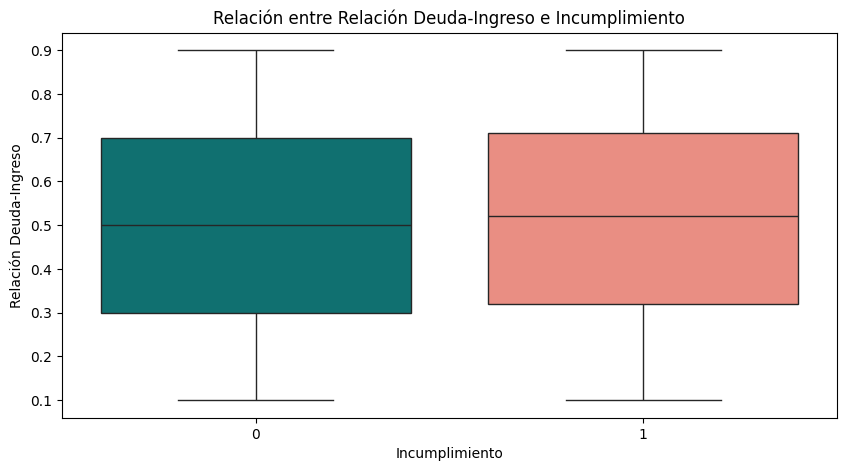

In [40]:
# DTIRatio (Relación Deuda-Ingreso)
DTIRatio = df['DTIRatio'].value_counts()
print(DTIRatio.sort_index())

# Histograma de la variable 'DTIRatio'
plt.figure(figsize=(10, 5))
sns.histplot(df['DTIRatio'], kde=True, color='teal')
plt.title('Distribución de la Relación Deuda-Ingreso')
plt.xlabel('Relación Deuda-Ingreso')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot de 'DTIRatio' vs 'Default'
plt.figure(figsize=(10, 5))
sns.boxplot(x='Default', y='DTIRatio', hue='Default', data=df, palette=['teal', 'salmon'], legend=False)
plt.title('Relación entre Relación Deuda-Ingreso e Incumplimiento')
plt.xlabel('Incumplimiento')
plt.ylabel('Relación Deuda-Ingreso')
plt.show()

**Variable:** EmploymentType  

**Distribución de los datos:** distribución uniforme.

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** no se puede concluir que ciertos tipos de empleo pueden estar asociados con un mayor riesgo de incumplimiento, porque la relación es bastante débil.

**Transformación:** one hot encoding, para convertir cada categoría en una columna binaria.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** casi todas las correlaciones son nulas, sólo algunas son debilmente negativas o positivas.

EmploymentType
Full-time        63656
Part-time        64161
Self-employed    63706
Unemployed       63824
Name: count, dtype: int64
EmploymentType
Full-time        63656
Part-time        64161
Self-employed    63706
Unemployed       63824
Name: count, dtype: int64


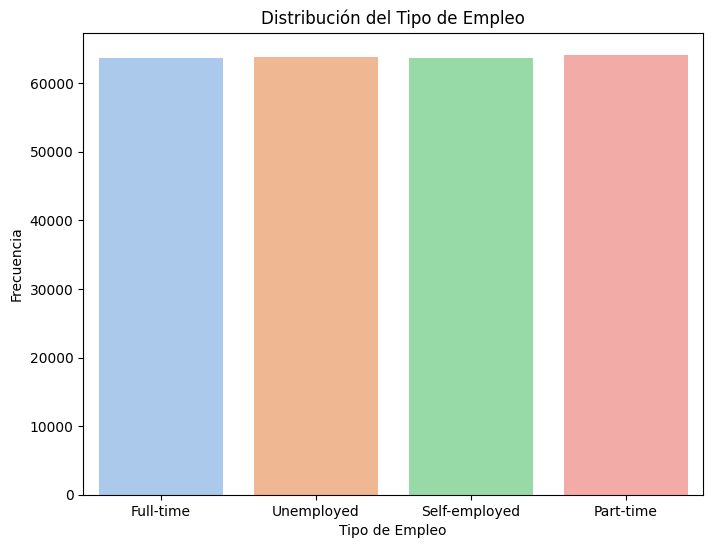

In [41]:
# EmploymentType (Tipo de Empleo)
EmploymentType = df['EmploymentType'].value_counts()
print(EmploymentType.sort_index())

# Frecuencia de cada tipo de empleo
employment_counts = df['EmploymentType'].value_counts()
print(employment_counts.sort_index())

# Gráfico de barras de 'EmploymentType'
plt.figure(figsize=(8, 6))
sns.countplot(x='EmploymentType', data=df, hue='EmploymentType', palette='pastel', legend=False)
plt.title('Distribución del Tipo de Empleo')
plt.xlabel('Tipo de Empleo')
plt.ylabel('Frecuencia')
plt.show()

**Variable:** HasDependents  

**Distribución de los datos:** casi mitad y mitad (Ver bien como poner)

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** tener dependientes puede estar asociado con una menor probabilidad de incumplimiento.

**Transformación:** label encoder (para que sea binaria).

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

HasDependents
No     49.973174
Yes    50.026826
Name: proportion, dtype: float64


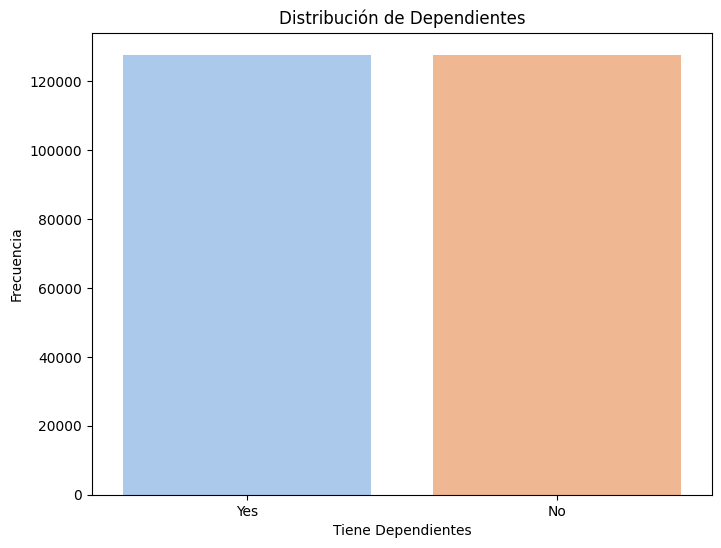

In [42]:
# HasDependents (Tiene Dependientes)

# Distribución de 'HasDependents'
dependents_dist = df['HasDependents'].value_counts(normalize=True) * 100
print(dependents_dist.sort_index())

# Gráfico de barras de 'HasDependents'
plt.figure(figsize=(8, 6))
sns.countplot(x='HasDependents', data=df, hue='HasDependents', palette='pastel', legend=False)
plt.title('Distribución de Dependientes')
plt.xlabel('Tiene Dependientes')
plt.ylabel('Frecuencia')
plt.show()

LoanPurpose (Propósito del Préstamo)

**Variable:** LoanPurpose  

**Distribución de los datos:** uniforme.

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** no se observa que el propósito del préstamo puede tener una asociación con una menor o mayor probabilidad de incumplimiento.

**Transformación:** one hot encoding, para convertir cada categoría en una columna binaria.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

LoanPurpose
Auto         50844
Business     51298
Education    51005
Home         51286
Other        50914
Name: count, dtype: int64


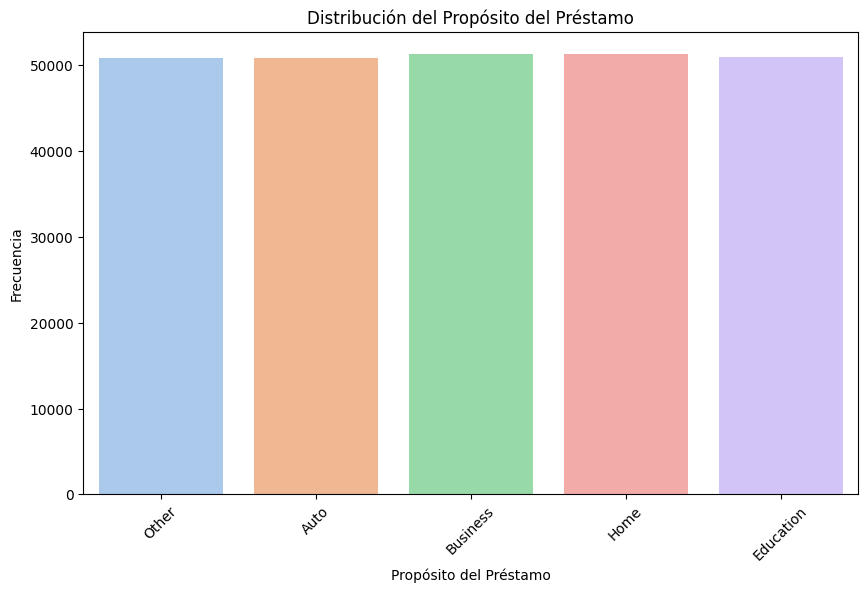

In [43]:
# Frecuencia de cada propósito del préstamo
purpose_counts = df['LoanPurpose'].value_counts()
print(purpose_counts.sort_index())

# Gráfico de barras de 'LoanPurpose'
plt.figure(figsize=(10, 6))
sns.countplot(x='LoanPurpose', data=df, hue='LoanPurpose', palette='pastel', legend=False)
plt.title('Distribución del Propósito del Préstamo')
plt.xlabel('Propósito del Préstamo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

MaritalStatus (Estado Civil)

**Variable:** MaritalStatus  

**Distribución de los datos:** 

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** se identifica una relación débil.

**Transformación:** one hot encoding, para convertir cada categoría en una columna binaria.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

MaritalStatus
Divorced    85033
Married     85302
Single      85012
Name: count, dtype: int64


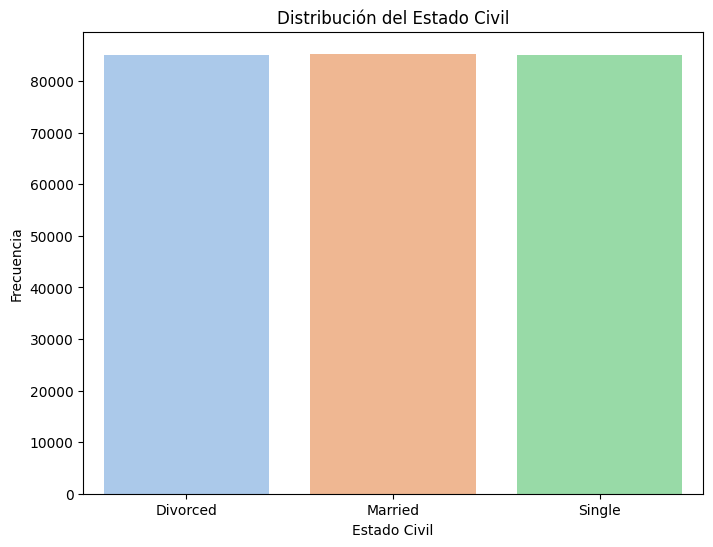

In [44]:
# Frecuencia de cada estado civil
marital_status_counts = df['MaritalStatus'].value_counts()
print(marital_status_counts.sort_index())

# Gráfico de barras de 'MaritalStatus'
plt.figure(figsize=(8, 6))
sns.countplot(x='MaritalStatus', data=df, hue='MaritalStatus', palette='pastel', legend=False)
plt.title('Distribución del Estado Civil')
plt.xlabel('Estado Civil')
plt.ylabel('Frecuencia')
plt.show()

**Variable:** MonthsEmployed  

**Distribución de los datos:** 

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** se identifica una relación débil, aunque se observa que el rango de personas que incumplen, es ligeramente mayor en personas con poco tiempo de tener un trabajo.

**Transformación:** normalizar.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

MonthsEmployed
0      2122
1      2105
2      2151
3      2167
4      2121
       ... 
115    2084
116    2130
117    2084
118    2196
119    2091
Name: count, Length: 120, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

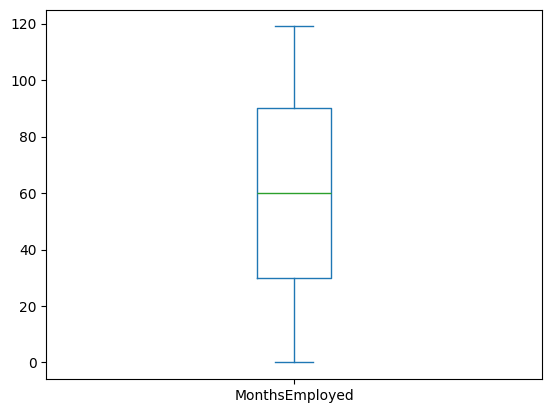

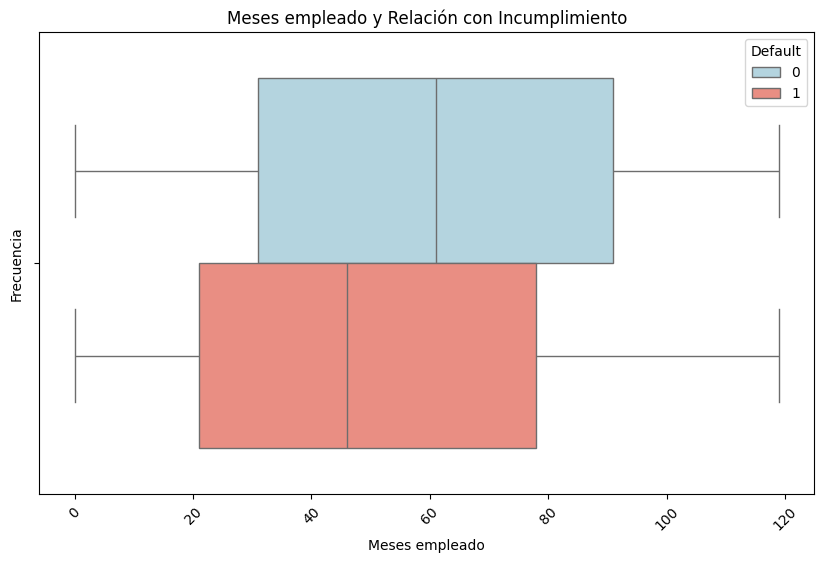

In [45]:
# MonthsEmployed (Meses que la persona ha estado empleado) 
months_employed = df['MonthsEmployed'].value_counts()
print(months_employed.sort_index())

# # Boxplot de 'MonthsEmployed'
df['MonthsEmployed'].plot.box()

# Gráfico de barras para 'MonthsEmployed' vs 'Default'
plt.figure(figsize=(10, 6))
sns.boxplot(x='MonthsEmployed', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Meses empleado y Relación con Incumplimiento')
plt.xlabel('Meses empleado')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show

**Variable:** NumCreditLines  

**Distribución de los datos:** uniforme.

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** se concluye que a mayor número de líneas de crédito, hay un mayor (aunque muy pequeño), incremento de riesgo de incumplimiento.

**Transformación:** normalizar.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

NumCreditLines
1    63554
2    64130
3    63834
4    63829
Name: count, dtype: int64


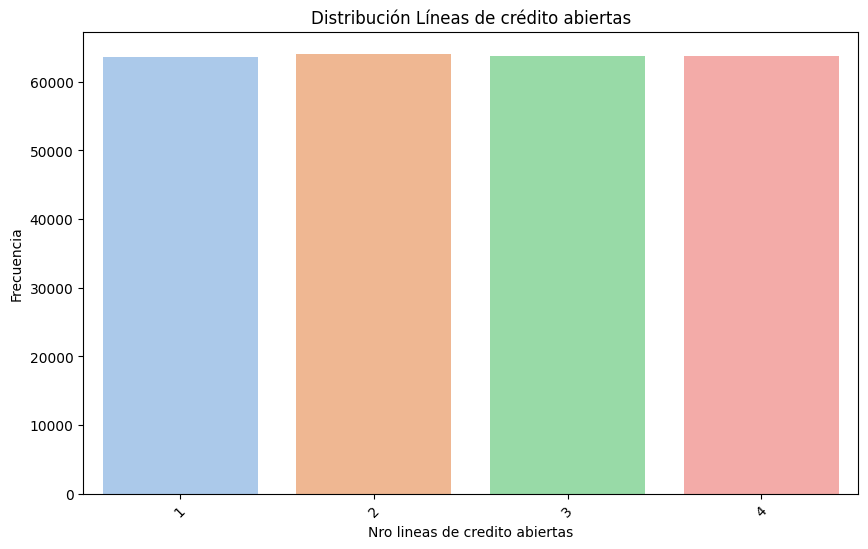

In [46]:
# NumCreditLines (Líneas de crédito abiertas)
num_CreditLines = df['NumCreditLines'].value_counts()
print(num_CreditLines.sort_index())

# Gráfico de barras de 'NumCreditLines'
plt.figure(figsize=(10, 6))
sns.countplot(x='NumCreditLines', data=df, hue='NumCreditLines', palette='pastel', legend=False)
plt.title('Distribución Líneas de crédito abiertas')
plt.xlabel('Nro lineas de credito abiertas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

**Variable:** InterestRate  

**Distribución de los datos:** uniforme.

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** a medida que la tasa de interés aumenta, la probabilidad de incumplimiento también tiende a aumentar.

**Transformación:** normalizar.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

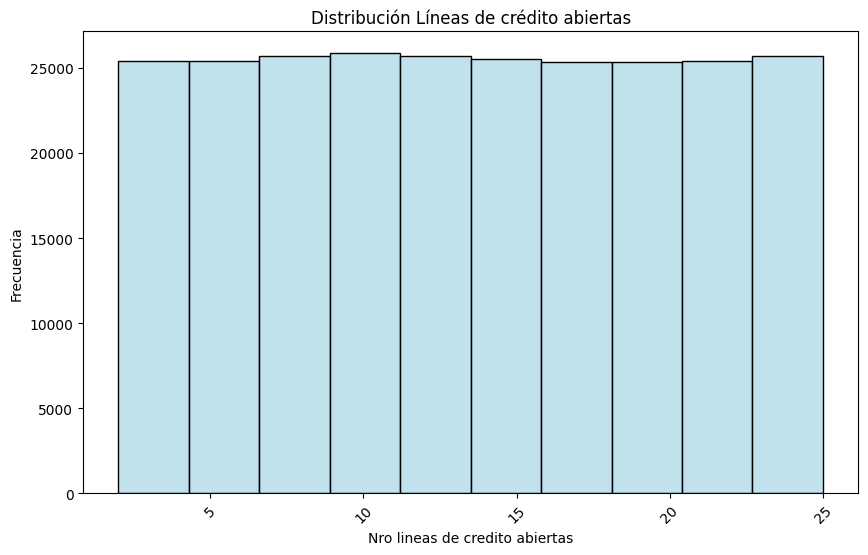

<Axes: >

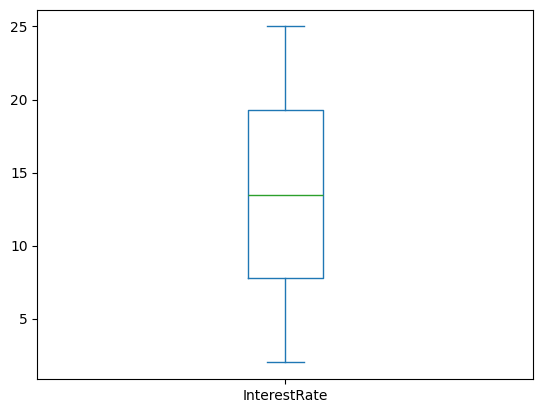

In [47]:
# InterestRate (Tasa de interés del préstamo)
interest_Rate = df['InterestRate'].value_counts()

# Histograma
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='InterestRate', bins=10, kde=False, color='lightblue')
plt.title('Distribución Líneas de crédito abiertas')
plt.xlabel('Nro lineas de credito abiertas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Boxplot de 'InterestRate'
df['InterestRate'].plot.box()

**Variable:** LoanTerm  

**Distribución de los datos:** uniforme. 

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** no influye en la probabilidad de incumplimiento del dataset.

**Transformación:** normalizar.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

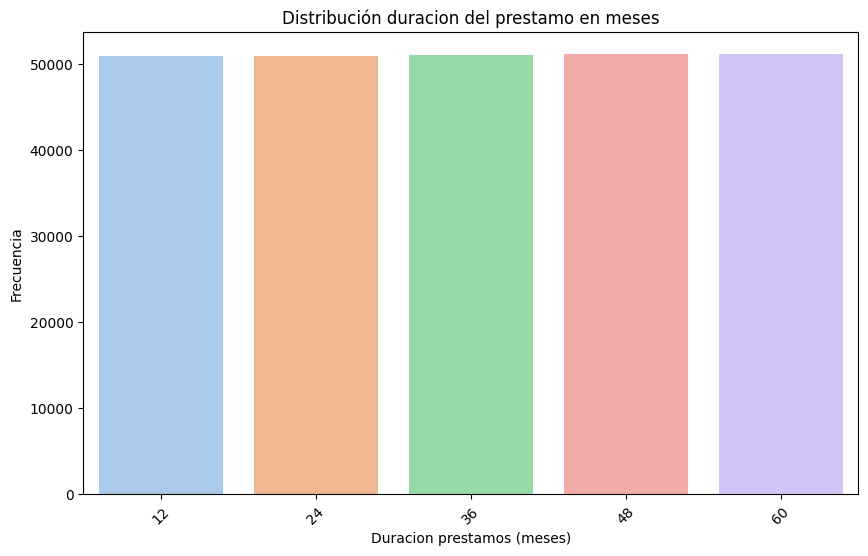

In [48]:
# LoanTerm (Duración del préstamo en meses) 
Loan_Term = df['LoanTerm'].value_counts()

# Gráfico de barras de 'LoanTerm'
plt.figure(figsize=(10, 6))
sns.countplot(x='LoanTerm', data=df, hue='LoanTerm', palette='pastel', legend=False)
plt.title('Distribución duracion del prestamo en meses')
plt.xlabel('Duracion prestamos (meses)')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

**Variable:** Education  

**Distribución de los datos:** uniforme. 

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:**  no hay una relación significativa entre el nivel educativo y la probabilidad de incumplimiento.

**Transformación:** one hot encoding, para convertir cada categoría en una columna binaria.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

Education
Bachelor's     64366
High School    63903
Master's       63541
PhD            63537
Name: count, dtype: int64


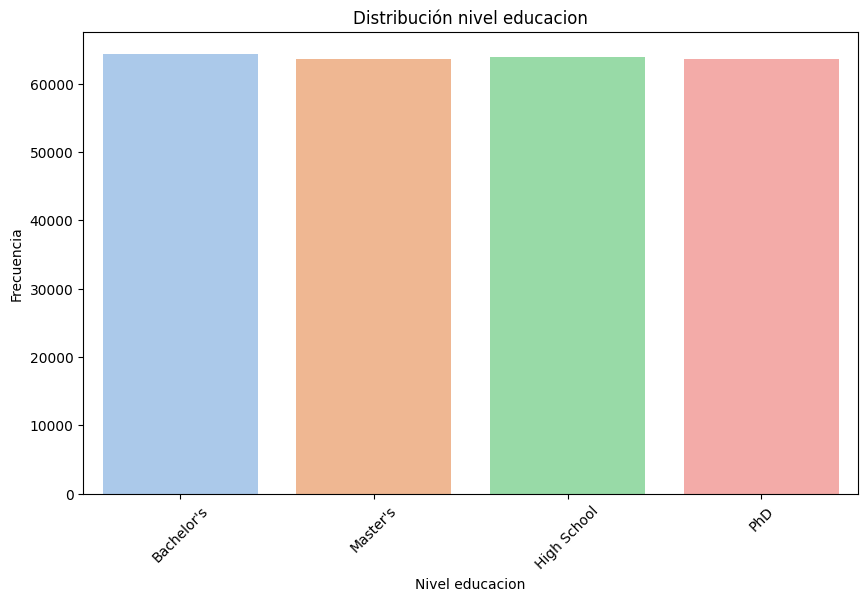

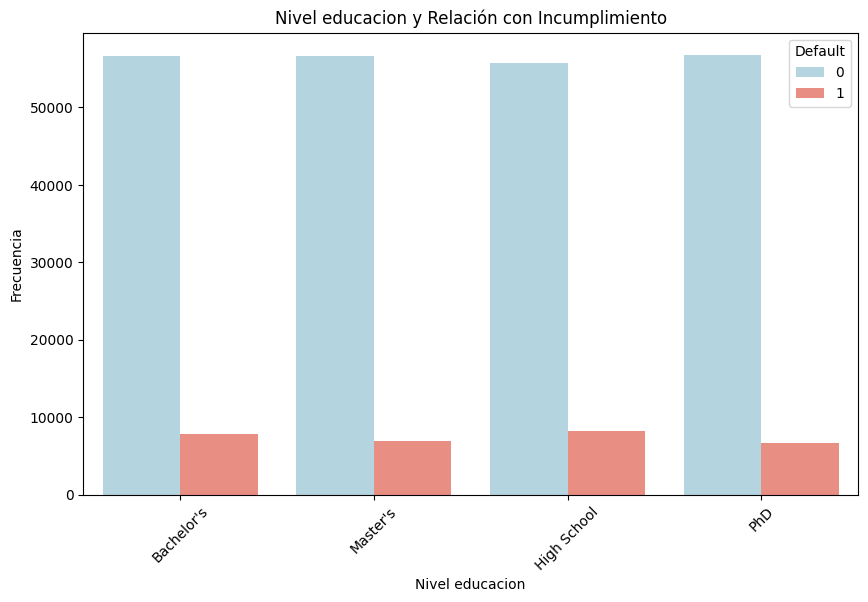

In [49]:
# Education (nivel educativo)
Education = df['Education'].value_counts()
print(Education.sort_index())

# Gráfico de barras de 'MonthsEmployed'
plt.figure(figsize=(10, 6))
sns.countplot(x='Education', data=df, hue='Education', palette='pastel', legend=False)
plt.title('Distribución nivel educacion')
plt.xlabel('Nivel educacion')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para 'Education' vs 'Default'
plt.figure(figsize=(10, 6))
sns.countplot(x='Education', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Nivel educacion y Relación con Incumplimiento')
plt.xlabel('Nivel educacion')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

**Variable:** HasMortgage  

**Distribución de los datos:** uniforme. 

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:**  tener una hipoteca disminuye ligeramente la posibilidad de incumplimiento.

**Transformación:** label encoder (para que pase a ser binaria).

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

HasMortgage
No     127670
Yes    127677
Name: count, dtype: int64


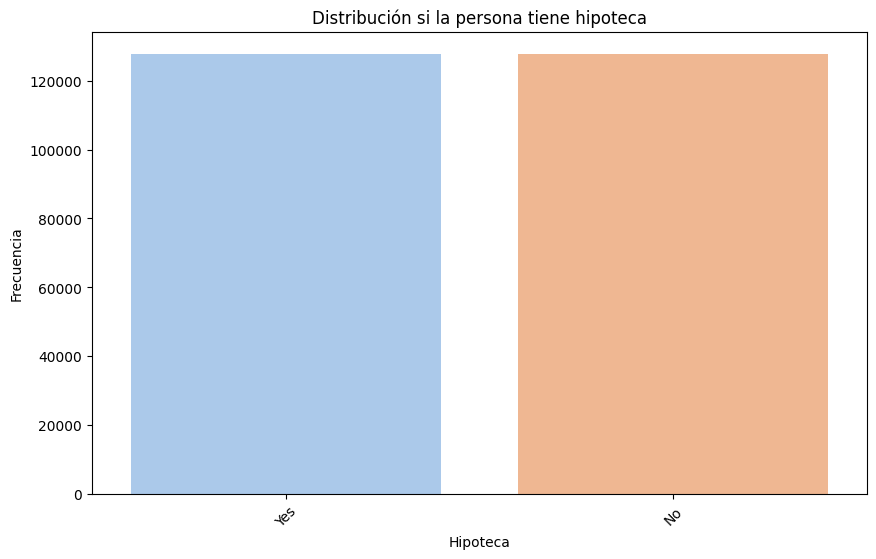

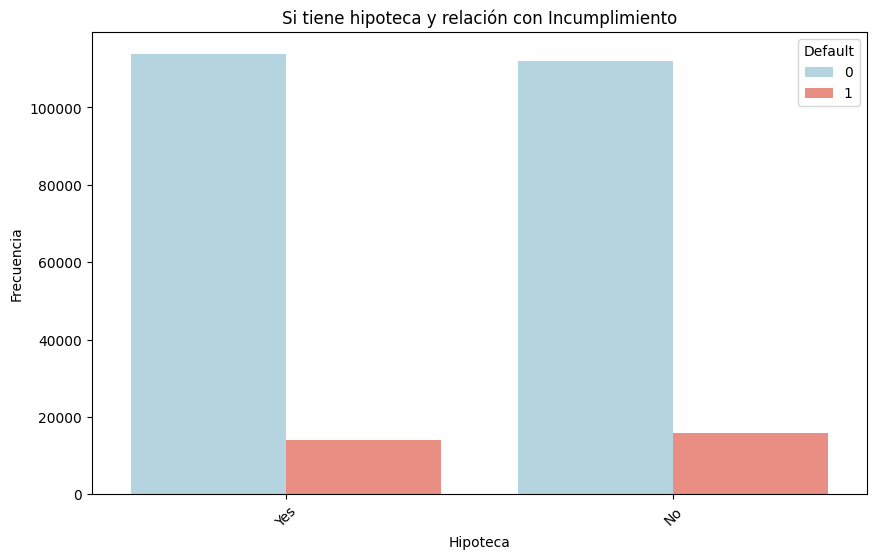

In [50]:
# HasMortgage (si la persona tiene una hipoteca)
Has_Mortgage = df['HasMortgage'].value_counts()
print(Has_Mortgage.sort_index())

# Gráfico de barras de 'HasMortgage'
plt.figure(figsize=(10, 6))
sns.countplot(x='HasMortgage', data=df, hue='HasMortgage', palette='pastel', legend=False)
plt.title('Distribución si la persona tiene hipoteca')
plt.xlabel('Hipoteca')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para 'HasMortgage' vs 'Default'
plt.figure(figsize=(10, 6))
sns.countplot(x='HasMortgage', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Si tiene hipoteca y relación con Incumplimiento')
plt.xlabel('Hipoteca')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

**Variable:** HasCoSigner  

**Distribución de los datos:** uniforme. 

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:**  no tener un garante aumenta la posibilidad de incumplimiento.

**Transformación:** label encoder (para que pase a ser binaria).

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

HasCoSigner
No     127646
Yes    127701
Name: count, dtype: int64


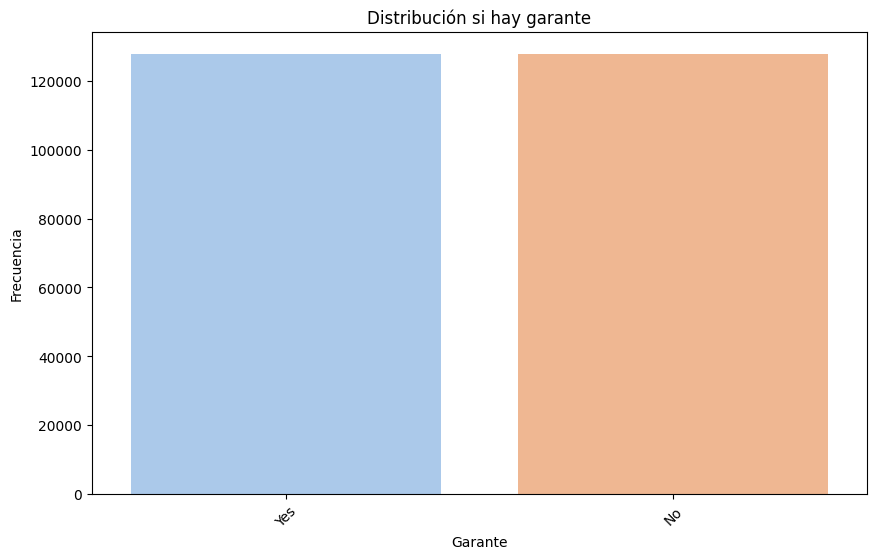

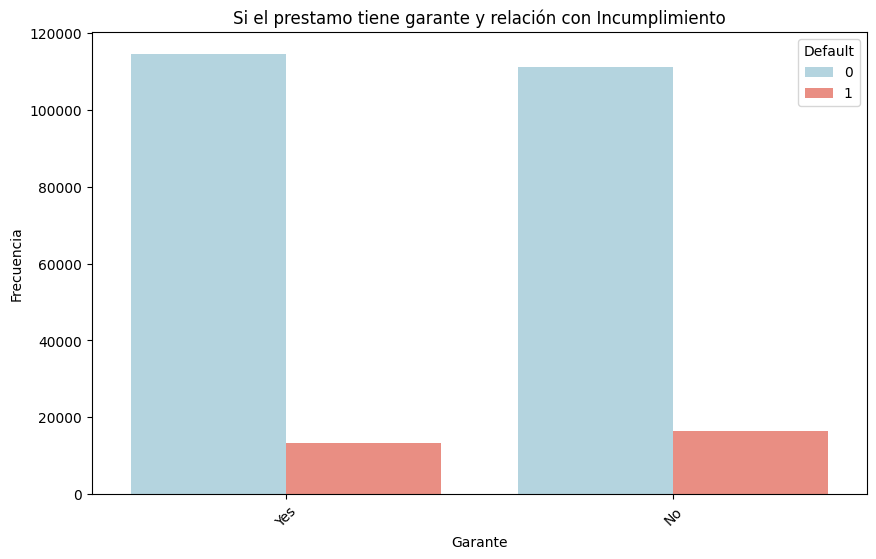

In [51]:
# Si el préstamo tiene un garante 
Has_CoSigner = df['HasCoSigner'].value_counts()
print(Has_CoSigner.sort_index())

# Gráfico de barras de 'HasCoSigner'
plt.figure(figsize=(10, 6))
sns.countplot(x='HasCoSigner', data=df, hue='HasCoSigner', palette='pastel', legend=False)
plt.title('Distribución si hay garante')
plt.xlabel('Garante')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para 'HasCoSigner' vs 'Default'
plt.figure(figsize=(10, 6))
sns.countplot(x='HasCoSigner', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Si el prestamo tiene garante y relación con Incumplimiento')
plt.xlabel('Garante')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

In [52]:
# Correlación entre las variables
from sklearn.preprocessing import LabelEncoder

# Codificar variables categóricas
label_encoder = LabelEncoder()

categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

# Seleccionar solo las variables numéricas
df_numeric = df.select_dtypes(include=['number'])

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

print(correlation_matrix)

                     Age    Income  LoanAmount  CreditScore  MonthsEmployed  \
Age             1.000000 -0.001244   -0.002213    -0.000548       -0.000341   
Income         -0.001244  1.000000   -0.000865    -0.001430        0.002675   
LoanAmount     -0.002213 -0.000865    1.000000     0.001261        0.002817   
CreditScore    -0.000548 -0.001430    0.001261     1.000000        0.000613   
MonthsEmployed -0.000341  0.002675    0.002817     0.000613        1.000000   
NumCreditLines -0.000890 -0.002016    0.000794     0.000016        0.001267   
InterestRate   -0.001127 -0.002303   -0.002291     0.000436        0.000096   
LoanTerm        0.000263 -0.000998    0.002538     0.001130       -0.001166   
DTIRatio       -0.004689  0.000205    0.001122    -0.001039        0.001765   
Education      -0.000882 -0.000965    0.002551     0.000214       -0.001304   
EmploymentType  0.000787 -0.005146    0.003060     0.003503        0.000564   
MaritalStatus  -0.002187  0.000637   -0.000771    -0

Correlaciones Generales
Default: La variable de interés Default tiene una correlación de -0.1678 con Age, que es una correlación moderada negativa. Esto sugiere que, en general, las personas mayores pueden tener una menor probabilidad de incumplir con el préstamo, aunque esta relación aún no es muy fuerte.

Variables Financieras:

Income: Tiene una correlación positiva moderada con Default (0.1313), sugiriendo que mayores ingresos podrían estar asociados con un menor incumplimiento.
LoanAmount: La correlación con Default es 0.0867, indicando una relación positiva débil.
CreditScore: La correlación con Default es -0.0342, muy débil y negativa, lo que sugiere que el puntaje de crédito no tiene una fuerte relación lineal con el incumplimiento.

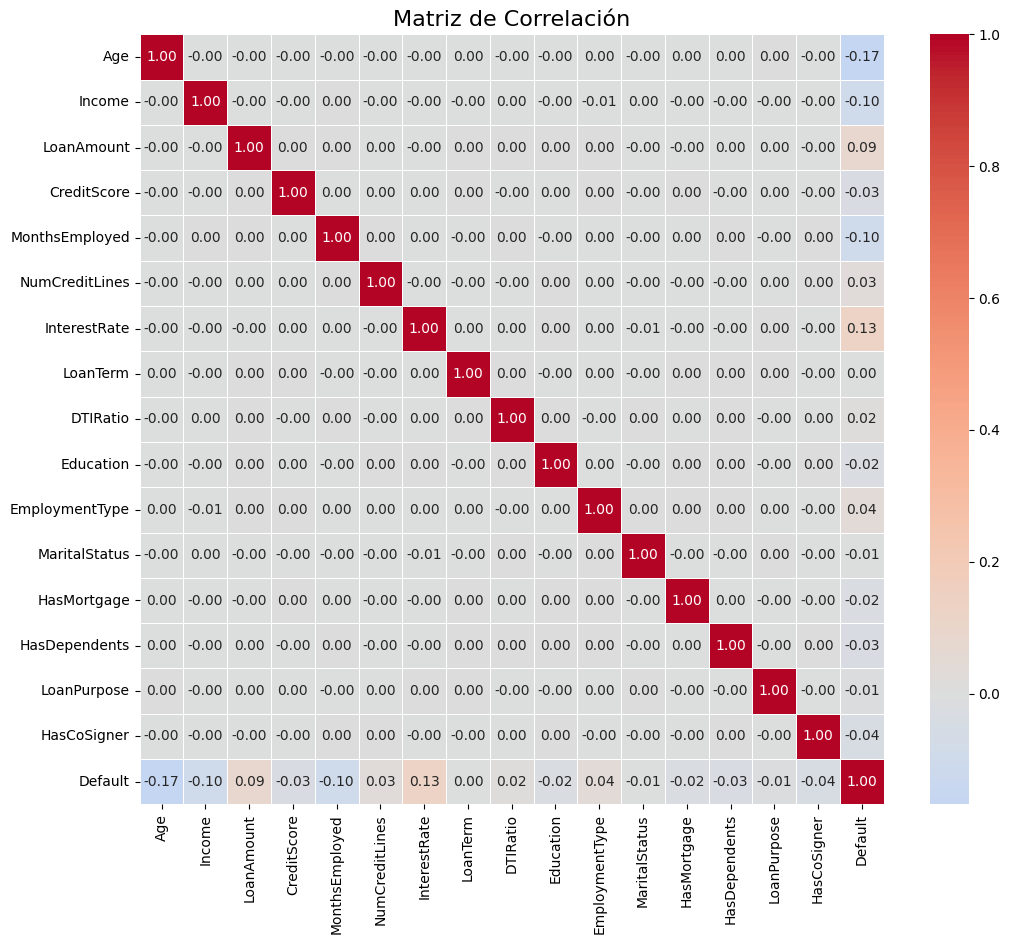

In [53]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 10))

# Crear el mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)

# Añadir título
plt.title('Matriz de Correlación', fontsize=16)

# Mostrar el gráfico
plt.show()


In [54]:
df_num.corr()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
Age,1.000000,-0.001244,-0.002213,-0.000548,-0.000341,-0.000890,-0.001127,0.000263,-0.004689,-0.167783
Income,-0.001244,1.000000,-0.000865,-0.001430,0.002675,-0.002016,-0.002303,-0.000998,0.000205,-0.099119
LoanAmount,-0.002213,-0.000865,1.000000,0.001261,0.002817,0.000794,-0.002291,0.002538,0.001122,0.086659
CreditScore,-0.000548,-0.001430,0.001261,1.000000,0.000613,0.000016,0.000436,0.001130,-0.001039,-0.034166
MonthsEmployed,-0.000341,0.002675,0.002817,0.000613,1.000000,0.001267,0.000096,-0.001166,0.001765,-0.097374
NumCreditLines,-0.000890,-0.002016,0.000794,0.000016,0.001267,1.000000,-0.000297,-0.000226,-0.000586,0.028330
InterestRate,-0.001127,-0.002303,-0.002291,0.000436,0.000096,-0.000297,1.000000,0.000892,0.000575,0.131273
LoanTerm,0.000263,-0.000998,0.002538,0.001130,-0.001166,-0.000226,0.000892,1.000000,0.002273,0.000545
DTIRatio,-0.004689,0.000205,0.001122,-0.001039,0.001765,-0.000586,0.000575,0.002273,1.000000,0.019236
Default,-0.167783,-0.099119,0.086659,-0.034166,-0.097374,0.028330,0.131273,0.000545,0.019236,1.000000


<Axes: >

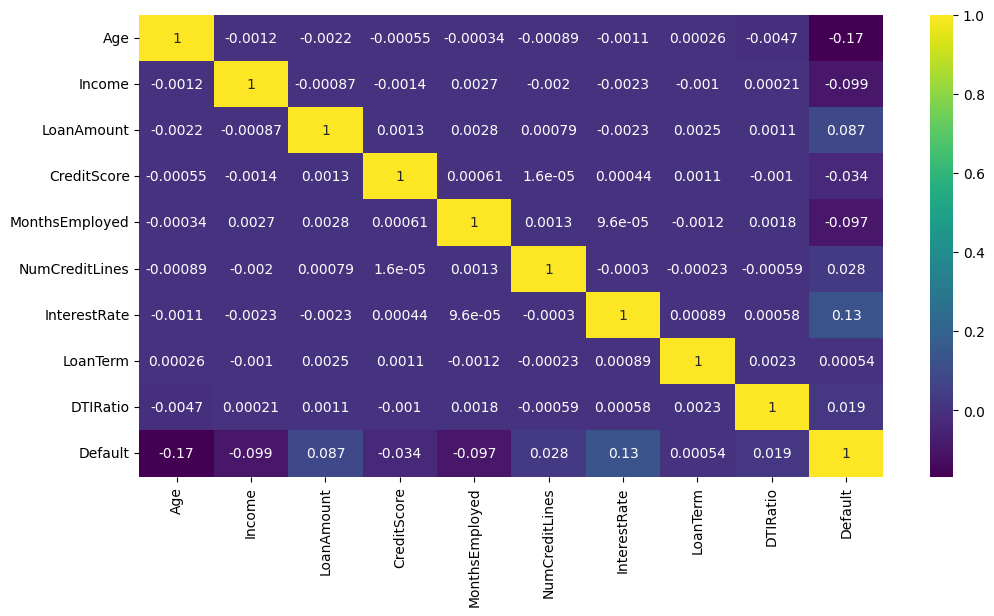

In [55]:
plt.figure(figsize = (12,6))
sns.heatmap(df_num.corr(), annot = True, cmap = 'viridis')

# Relaciones lineales

Income y Default:
Correlación: -0.099119 (-0.10 redondeado).
Ingresos más altos están ligeramente asociados con una menor probabilidad de incumplimiento.

InterestRate y Default:
Correlación: 0.131273
Préstamos con tasas de interés más altas están asociados con un mayor riesgo de incumplimiento.


# Preguntas/dudas:

0- ¿Hay alguna variable que creas que es especialmente importante para el análisis que no está claramente documentada en el dataset?

1- ¿Cómo se manejan los valores faltantes en el dataset?

2- ¿Hay alguna información sobre cómo se realizó la recopilación de los datos y la metodología utilizada para asegurar su calidad?

3- ¿Podrías proporcionar algún ejemplo de cómo se han usado estos datos?

4- ¿Cómo se definieron y calcularon las variables categóricas como EmploymentType, MaritalStatus, y LoanPurpose?

# Detección de valores nulos y extremos

In [56]:
df.isnull().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

# Estadísticas descriptivas

In [57]:
df.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,1.494421,1.500096,0.999918,0.500014,0.500268,2.000501,0.500108,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,1.118826,1.117358,0.816051,0.500001,0.500001,1.412723,0.500001,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,2.000000,2.000000,2.000000,1.000000,1.000000,3.000000,1.000000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,1.000000,1.000000


# No hay duplicados

In [58]:
df[df.duplicated()]

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default


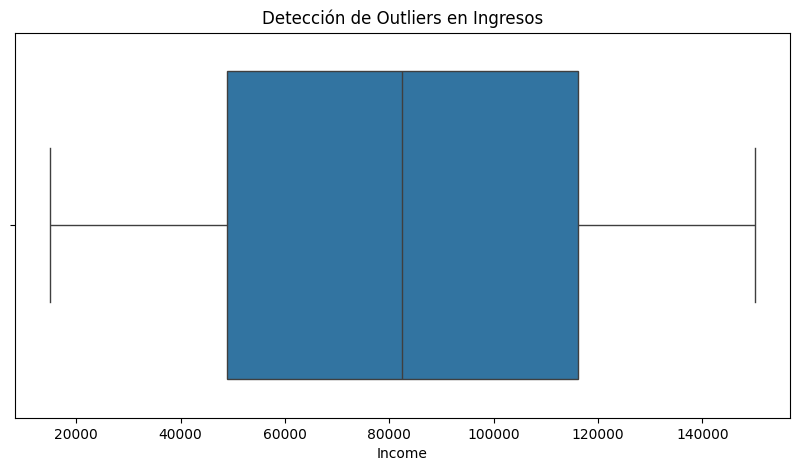

In [59]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Income'])
plt.title('Detección de Outliers en Ingresos')
plt.show()

# 3. Hipótesis sobre los datos

Hipótesis 1: Las personas con un alto ingresos tienen menos probabilidad de incumplimiento de pago.

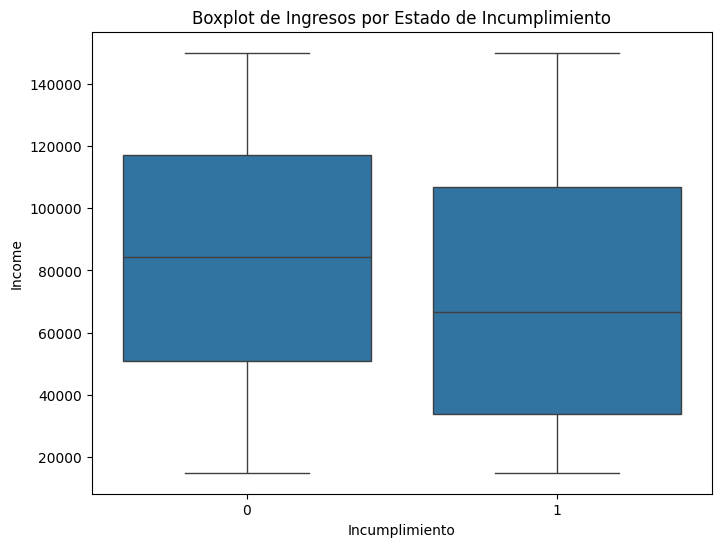

Coeficiente de correlación entre Income y Default: -0.09911948445660432


In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, f1_score

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Default', y='Income', data=df)
plt.title('Boxplot de Ingresos por Estado de Incumplimiento')
plt.xlabel('Incumplimiento')
plt.ylabel('Income')
plt.show()

# Análisis Estadístico
# Correlación
correlation = df[['Income', 'Default']].corr().loc['Income', 'Default']
print(f'Coeficiente de correlación entre Income y Default: {correlation}')

Podemos ver que los ingresos de quienes incumplen son más bajos en promedio. Ademas, el coeficiente de correlacion nos indica que hay una relacion lineal negativa, es decir, entre mas bajo, mas chances de incumplimiento. 

# Hipótesis 2

Un mayor número de cuotas distribuye el pago total del préstamo en períodos más largos, lo que reduce el monto de cada cuota mensual, reduce la probabilidad de incumplimiento. Se refuta esta hipótesis.

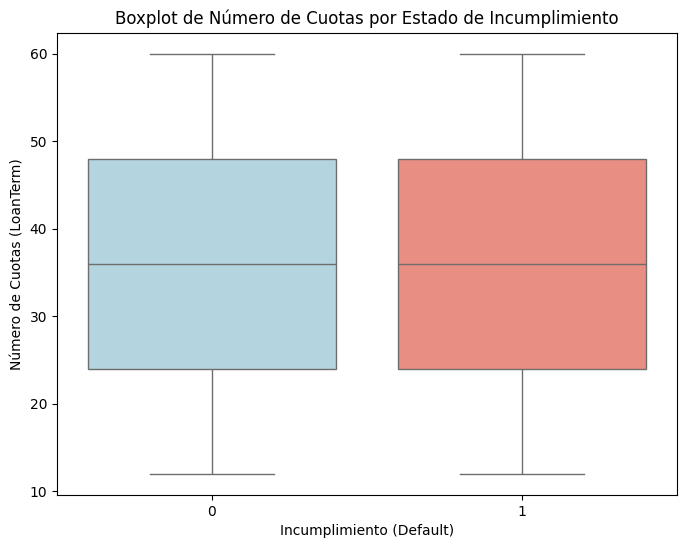

Coeficiente de correlación entre LoanTerm y Default: 0.0005446976963164581


In [61]:
# Boxplot para 'LoanTerm' por estado de incumplimiento
palette = {0: 'lightblue', 1: 'salmon'}

# Crear el boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Default', y='LoanTerm', data=df, hue='Default', palette=palette, legend=False)

# Añadir título y etiquetas
plt.title('Boxplot de Número de Cuotas por Estado de Incumplimiento')
plt.xlabel('Incumplimiento (Default)')
plt.ylabel('Número de Cuotas (LoanTerm)')

# Mostrar el gráfico
plt.show()

# Análisis Estadístico
# Correlación
correlation = df[['LoanTerm', 'Default']].corr().loc['LoanTerm', 'Default']
print(f'Coeficiente de correlación entre LoanTerm y Default: {correlation}')

No se cumple, debido a que no hay una tendencia que implique que a mayor cantidad de cuotas menor la chance de incumplimiento. Ademas, podemos ver una correlacion muy cercana a 0 lo que implica que no hay una relacion lineal entre LoanTerm y Defautl.

# Hipótesis 3

Nivel de CreditScore, a mayor nivel, menor chance de incumplimiento.

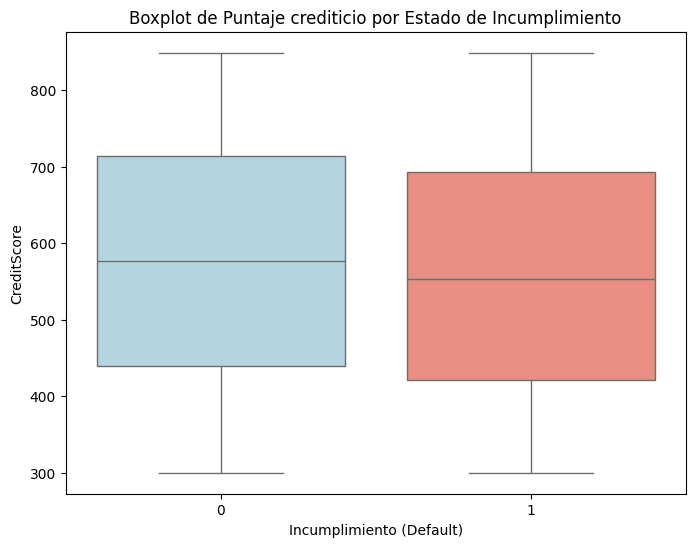

Coeficiente de correlación entre CreditScore y Default: -0.03416649376077075


In [62]:
# Boxplot para 'LoanTerm' por estado de incumplimiento
palette = {0: 'lightblue', 1: 'salmon'}

# Crear el boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Default', y='CreditScore', data=df, hue='Default', palette=palette, legend=False)

# Añadir título y etiquetas
plt.title('Boxplot de Puntaje crediticio por Estado de Incumplimiento')
plt.xlabel('Incumplimiento (Default)')
plt.ylabel('CreditScore')

# Mostrar el gráfico
plt.show()

# Análisis Estadístico
# Correlación
correlation = df[['CreditScore', 'Default']].corr().loc['CreditScore', 'Default']
print(f'Coeficiente de correlación entre CreditScore y Default: {correlation}')

Para esta hipotesis, podemos afirmar que las personas que no incumplieron en promedio tienen un CreditScore mayor a las que si lo hicieron. Además, el coeficiente de correlacion nos indica que entre mayor CreditScore, menor posibilidad de incumplimiento hay. 

# Hipótesis 4

¿Las personas mayores son más incumplidoras?

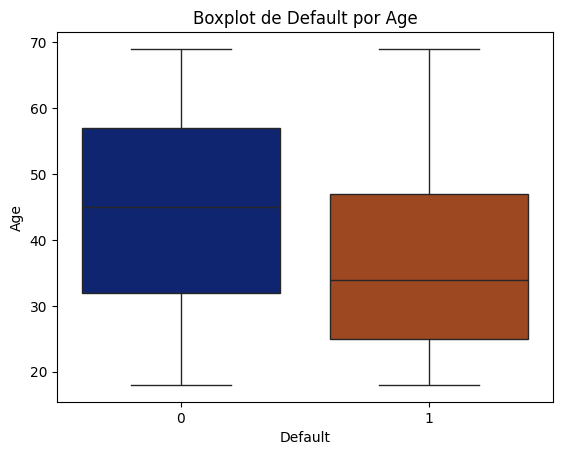

            count       mean        std   min   25%   50%   75%   max
Default                                                              
0        225694.0  44.409962  14.889574  18.0  32.0  45.0  57.0  69.0
1         29653.0  36.559539  13.897468  18.0  25.0  34.0  47.0  69.0


In [63]:
sns.boxplot(x='Default', y='Age', data=df, hue='Default', palette='dark', legend=False)
plt.title(f'Boxplot de Default por Age')
plt.show()

# Estadísticas descriptivas por grupo de Default
age_stats = df.groupby('Default')['Age'].describe()
print(age_stats)

Se refuta la hipótesis. Las personas que incumplen los préstamos son en promedio más jóvenes que aquellas que no incumplen.

# Hallazgos adicionales:

InterestRate y Default: la correlación entre InterestRate y Default es positiva (0.131273), indicando que un aumento en la tasa de interés está asociado con un mayor riesgo de incumplimiento. Esto puede tener sentido, ya que tasas de interés más altas pueden hacer que los pagos sean más difíciles de manejar.

HasMortgage y Default: la correlación entre HasMortgage y Default es negativa (-0.022856), lo que sugiere que tener una hipoteca disminuye ligeramente la posibilidad de incumplimiento.

# Impacto en la creación del modelo:

Incluir Income: basado en la hipótesis validada, Income es una variable importante a incluir en el modelo predictivo, ya que tiene una relación significativa con la probabilidad de incumplimiento.

Tasa de interés: dado el hallazgo de una relación positiva entre InterestRate y Default, es crucial incluir esta variable en el modelo para capturar su impacto en la probabilidad de incumplimiento.

#  Creación de nuevas variables:

Una variable que pensamos en crear, es una que tenga la relación entre Income e InterestRate, creíamos que podría ayudar a identificar cómo los ingresos y las tasas de interés combinados afectan el riesgo de incumplimiento, ya que suponiamos que los clientes con mayores ingresos tienen acceso a productos financieros más favorables, lo que les permite obtener préstamos a tasas de interés más bajas. Pero nos percatamos de que, multiplicar Income por InterestRate combina ambas variables de una forma no lineal. El resultado puede ser confuso porque, aunque esperábamos que a mayor ingreso haya una tasa más baja, el valor de la nueva variable depende de ambas cosas al mismo tiempo. Así que, en lugar de aclarar la relación, la complica.

# 4. Modelado

In [3]:
class_distribution = df['Default'].value_counts()
class_proportions = df['Default'].value_counts(normalize=True)

result_df = pd.DataFrame({
    'Count': class_distribution,
    'Proportion': class_proportions
})

result_df['Proportion'] = result_df['Proportion'].apply(lambda x: f"{x:.2%}")

print(result_df)

          Count Proportion
Default                   
0        225694     88.39%
1         29653     11.61%


# Metrica a utilizar: F1-Score

Teniendo en cuenta los resultados obtenidos, sabemos que el dataset está claramente desbalanceado, con un 88% de ejemplos que no son default y solo un 12% que sí son default. Por un lado, precision va a ayudarnos a medir el porcentaje de predicciones positivas correctas, pero en un dataset desbalanceado como el que tenemos, si la utilizamos sola puede ser engañosa. Recall va a medir qué tan bien el modelo detecta todos los casos positivos reales, pero puede no ser suficiente si el modelo predice muchos falsos positivos. Por lo tanto, vamos a optar por la métrica F1-Score, ya que es una combinación equilibrada de precision y recall, que en este caso, va a ayudarnos a garantizar que tanto los casos positivos se detecten correctamente (recall) como que se eviten muchos falsos positivos (precision), sin favorecer una métrica sobre la otra.

# Label encoder

In [2]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
obj_col = ['HasCoSigner','LoanPurpose','HasDependents', 'HasMortgage','MaritalStatus', 'EmploymentType', 'Education']
for col in obj_col:
    df[col] = le.fit_transform(df[col])
    
df = df.drop(['LoanID'], axis=1)

In [11]:
X = df.drop(['Default'], axis=1)
y = df['Default']

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
#from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Imprimir la proporción de clases original
print("Class Imbalance")
print(y.value_counts(normalize=True))

# Aplicar SMOTE para balancear el dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Imprimir la proporción de clases después de aplicar SMOTE
print("\nAfter SMOTE")
print(y_resampled.value_counts(normalize=True))

# Dividir el dataset balanceado en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

# Lista de modelos para evaluar
models = [
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=42),
    LogisticRegression(max_iter=1000, random_state=42),
]

print()

# Evaluar cada modelo
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    model_name = model.__class__.__name__
    print(f'{model_name} - Precisión: {accuracy:.2f}, F1 Score: {f1:.4f}')


Class Imbalance
Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64

After SMOTE
Default
0    0.5
1    0.5
Name: proportion, dtype: float64

KNeighborsClassifier - Precisión: 0.76, F1 Score: 0.7800
RandomForestClassifier - Precisión: 0.88, F1 Score: 0.8734
LogisticRegression - Precisión: 0.75, F1 Score: 0.7496


C:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# GridSearchCV 
Para encontrar los mejores hiper-parámetros

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import numpy as np

# Imprimir la proporción de clases original
print("Class Imbalance")
print(y.value_counts(normalize=True))

# Aplicar SMOTE para balancear el dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Imprimir la proporción de clases después de aplicar SMOTE
print("\nAfter SMOTE")
print(y_resampled.value_counts(normalize=True))

# Dividir el dataset balanceado en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

# Definir los hiperparámetros para GridSearchCV
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Crear los modelos para GridSearchCV
models = {
    'KNeighborsClassifier': (KNeighborsClassifier(), param_grid_knn),
    'RandomForestClassifier': (RandomForestClassifier(random_state=42), param_grid_rf),
    'LogisticRegression': (LogisticRegression(max_iter=1000, random_state=42), param_grid_log_reg),
}

# Evaluar cada modelo usando GridSearchCV
for model_name, (model, param_grid) in models.items():
    print(f"\nEvaluating {model_name}")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f'Best Parameters for {model_name}: {grid_search.best_params_}')
    print(f'{model_name} - Precisión: {accuracy:.2f}, F1 Score: {f1:.4f}')

Class Imbalance
Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64

After SMOTE
Default
0    0.5
1    0.5
Name: proportion, dtype: float64

Evaluating KNeighborsClassifier
Best Parameters for KNeighborsClassifier: {'n_neighbors': 3, 'weights': 'distance'}
KNeighborsClassifier - Precisión: 0.78, F1 Score: 0.8055

Evaluating RandomForestClassifier
Best Parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
RandomForestClassifier - Precisión: 0.88, F1 Score: 0.8747

Evaluating LogisticRegression
Best Parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression - Precisión: 0.78, F1 Score: 0.7840


# Entrenamiento de modelos, sin feature engineering

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import numpy as np

# Imprimir la proporción de clases original
print("Class Imbalance")
print(y.value_counts(normalize=True))

# Aplicar SMOTE para balancear el dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Imprimir la proporción de clases después de aplicar SMOTE
print("\nAfter SMOTE")
print(y_resampled.value_counts(normalize=True))

# Dividir el dataset balanceado en entrenamiento y prueba
X_train_full, X_test, y_train_full, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {X_val.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

# Definir los hiperparámetros para GridSearchCV
param_grid_knn = {
    'n_neighbors': [3],
    'weights': ['distance']
}

param_grid_rf = {
    'n_estimators': [150],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

param_grid_log_reg = {
    'C': [0.1],
    'penalty': ['l1'],
    'solver': ['liblinear']
}

# Crear los modelos para GridSearchCV
models = {
    'KNeighborsClassifier': (KNeighborsClassifier(), param_grid_knn),
    'RandomForestClassifier': (RandomForestClassifier(random_state=42), param_grid_rf),
    'LogisticRegression': (LogisticRegression(max_iter=1000, random_state=42), param_grid_log_reg),
}

# Evaluar cada modelo usando GridSearchCV
for model_name, (model, param_grid) in models.items():
    print(f"\nEvaluating {model_name}")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f'{model_name} - Precisión: {accuracy:.2f}, F1 Score: {f1:.4f}')

Class Imbalance
Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64

After SMOTE
Default
0    0.5
1    0.5
Name: proportion, dtype: float64
Tamaño del conjunto de entrenamiento: 270832
Tamaño del conjunto de validación: 90278
Tamaño del conjunto de prueba: 90278

Evaluating KNeighborsClassifier
KNeighborsClassifier - Precisión: 0.77, F1 Score: 0.7925

Evaluating RandomForestClassifier
RandomForestClassifier - Precisión: 0.87, F1 Score: 0.8689

Evaluating LogisticRegression
LogisticRegression - Precisión: 0.78, F1 Score: 0.7837


# Resultados obtenidos:

Evaluating KNeighborsClassifier

- Best Parameters for KNeighborsClassifier: {'n_neighbors': 3, 'weights': 'distance'}
- KNeighborsClassifier - Precisión: 0.78, F1 Score: 0.8055

Evaluating RandomForestClassifier
- Best Parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
- RandomForestClassifier - Precisión: 0.88, F1 Score: 0.8747

Evaluating LogisticRegression
- Best Parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
- LogisticRegression - Precisión: 0.78, F1 Score: 0.7840

# Modelo elegido: RandomForest:
- Best Parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
- RandomForestClassifier - Precisión: 0.88, F1 Score: 0.8747

# En base a los resultados, realizaremos las siguientes feature engineering

# Normalizacion/Estandarizacion de las variables 


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd

# Dividir las columnas
categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
binary_columns = ['HasMortgage', 'HasDependents', 'HasCoSigner']
numeric_columns = ['Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                   'NumCreditLines', 'InterestRate', 'LoanTerm', 'Age']

# Definir el orden para las variables ordinales
education_order = ["High School", "Bachelor's", "Master's", "PhD"]
employment_order = ["Unemployed", "Part-time", "Full-time", "Self-employed"]

# Codificación ordinal para las variables ordinales
ordinal_encoder = OrdinalEncoder(categories=[education_order, employment_order])

# Clase para LabelEncoder en múltiples columnas
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        self.encoders_ = {col: LabelEncoder().fit(X[col]) for col in self.columns}
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = self.encoders_[col].transform(X_copy[col])
        return X_copy

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

# Pipeline de transformaciones
mapper = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('label', MultiColumnLabelEncoder(columns=binary_columns), binary_columns),
        ('num', StandardScaler(), numeric_columns),
    ]
)

# Crear pipeline con imputación y transformación
pipeline_transform = Pipeline([
    ('mapper', mapper),
    ('imputer', SimpleImputer(strategy='mean'))
])

# Transformar los datos
X_transformed = pipeline_transform.fit_transform(X)

# Aplicar SMOTE después de las transformaciones
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

# Dividir el dataset balanceado en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

# Definir el modelo RandomForest con los hiperparámetros específicos
rf = RandomForestClassifier(
    n_estimators=150, 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    random_state=42
)

# Entrenar el modelo
rf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = rf.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir los resultados
print(f'RandomForestClassifier - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')


RandomForestClassifier - Accuracy: 0.9440, F1 Score: 0.9424


# 1. Cuartiles, DTIRadio

- Consideramos que podriamos realizar cuartiles para determinar los distintos niveles de capacidad de pago de los clientes ya que esta variable era la relacion entre la deuda y los ingresos de la persona. Desde muy baja, baja, moderado, alto nivel de capacidad de pago. 

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd

# Dividir las columnas
categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
binary_columns = ['HasMortgage', 'HasDependents', 'HasCoSigner']
numeric_columns = ['Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                   'NumCreditLines', 'InterestRate', 'LoanTerm', 'Age']

# Definir el orden para las variables ordinales
education_order = ["High School", "Bachelor's", "Master's", "PhD"]
employment_order = ["Unemployed", "Part-time", "Full-time", "Self-employed"]

# Codificación ordinal para las variables ordinales
ordinal_encoder = OrdinalEncoder(categories=[education_order, employment_order])

# Clase para LabelEncoder en múltiples columnas
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        self.encoders_ = {col: LabelEncoder().fit(X[col]) for col in self.columns}
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = self.encoders_[col].transform(X_copy[col])
        return X_copy

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

# Pipeline de transformaciones
mapper = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('label', MultiColumnLabelEncoder(columns=binary_columns), binary_columns),
        ('num', StandardScaler(), numeric_columns),
        # Aplicar cambio en DTIRatio
        ('dti_quartiles', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile'), ['DTIRatio'])
    ]
)

# Crear pipeline con imputación y transformación
pipeline_transform = Pipeline([
    ('mapper', mapper),
    ('imputer', SimpleImputer(strategy='mean'))
])

# Transformar los datos
X_transformed = pipeline_transform.fit_transform(X)

# Aplicar SMOTE después de las transformaciones
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

# Dividir el dataset balanceado en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

# Definir el modelo RandomForest con los hiperparámetros específicos
rf = RandomForestClassifier(
    n_estimators=150, 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    random_state=42
)

# Entrenar el modelo
rf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = rf.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir los resultados
print(f'RandomForestClassifier - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')


RandomForestClassifier - Accuracy: 0.9448, F1 Score: 0.9429


# Resultado obtenido:
RandomForestClassifier - Accuracy: 0.9448, F1 Score: 0.9429

Utilizaremos este feature engineering debido a que la metrica no mejora. 


# 2. Cuartiles, Age 

- Agrupación de edad: Crear cuartiles para Age (por ejemplo, jóvenes,jovenes-adultos, adultos, mayores) puede ayudar a que el modelo capte mejor las diferencias en riesgo de acuerdo a la etapa de la vida de las personas.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd

# Dividir las columnas
categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
binary_columns = ['HasMortgage', 'HasDependents', 'HasCoSigner']
numeric_columns = ['Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                   'NumCreditLines', 'InterestRate', 'LoanTerm', 'Age']

# Definir el orden para las variables ordinales
education_order = ["High School", "Bachelor's", "Master's", "PhD"]
employment_order = ["Unemployed", "Part-time", "Full-time", "Self-employed"]

# Codificación ordinal para las variables ordinales
ordinal_encoder = OrdinalEncoder(categories=[education_order, employment_order])

# Clase para LabelEncoder en múltiples columnas
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        self.encoders_ = {col: LabelEncoder().fit(X[col]) for col in self.columns}
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = self.encoders_[col].transform(X_copy[col])
        return X_copy

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

# Pipeline de transformaciones
mapper = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('label', MultiColumnLabelEncoder(columns=binary_columns), binary_columns),
        ('num', StandardScaler(), numeric_columns),
        # Aplicar cambio en DTIRatio
        ('dti_quartiles', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile'), ['DTIRatio']),
        ('age_quartiles', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile'), ['Age'])
    ]
)

# Crear pipeline con imputación y transformación
pipeline_transform = Pipeline([
    ('mapper', mapper),
    ('imputer', SimpleImputer(strategy='mean'))
])

# Transformar los datos
X_transformed = pipeline_transform.fit_transform(X)

# Aplicar SMOTE después de las transformaciones
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

# Dividir el dataset balanceado en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

# Definir el modelo RandomForest con los hiperparámetros específicos
rf = RandomForestClassifier(
    n_estimators=150, 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    random_state=42
)

# Entrenar el modelo
rf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = rf.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir los resultados
print(f'RandomForestClassifier - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')


RandomForestClassifier - Accuracy: 0.9442, F1 Score: 0.9422


# Resultado obtenido:
RandomForestClassifier - Accuracy: 0.9442, F1 Score: 0.9422

No utilizaremos este feature engineering debido a que la metrica elegida no la mejora. 


# 3. Cuartiles, Income 


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd

# Dividir las columnas
categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
binary_columns = ['HasMortgage', 'HasDependents', 'HasCoSigner']
numeric_columns = ['Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                   'NumCreditLines', 'InterestRate', 'LoanTerm', 'Age']

# Definir el orden para las variables ordinales
education_order = ["High School", "Bachelor's", "Master's", "PhD"]
employment_order = ["Unemployed", "Part-time", "Full-time", "Self-employed"]

# Codificación ordinal para las variables ordinales
ordinal_encoder = OrdinalEncoder(categories=[education_order, employment_order])

# Clase para LabelEncoder en múltiples columnas
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        self.encoders_ = {col: LabelEncoder().fit(X[col]) for col in self.columns}
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = self.encoders_[col].transform(X_copy[col])
        return X_copy

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

# Pipeline de transformaciones
mapper = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('label', MultiColumnLabelEncoder(columns=binary_columns), binary_columns),
        ('num', StandardScaler(), numeric_columns),
        # Aplicar cambio en DTIRatio
        ('dti_quartiles', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile'), ['DTIRatio']),
        ('income_quartiles', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile'), ['Income'])
    ]
)

# Crear pipeline con imputación y transformación
pipeline_transform = Pipeline([
    ('mapper', mapper),
    ('imputer', SimpleImputer(strategy='mean'))
])

# Transformar los datos
X_transformed = pipeline_transform.fit_transform(X)

# Aplicar SMOTE después de las transformaciones
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

# Dividir el dataset balanceado en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

# Definir el modelo RandomForest con los hiperparámetros específicos
rf = RandomForestClassifier(
    n_estimators=150, 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    random_state=42
)

# Entrenar el modelo
rf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = rf.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir los resultados
print(f'RandomForestClassifier - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')


RandomForestClassifier - Accuracy: 0.9436, F1 Score: 0.9416


# Resultado obtenido:
RandomForestClassifier - Accuracy: 0.9436, F1 Score: 0.9416

No utilizaremos este feature engineering debido a que la metrica elegida no la mejora. 


# 4. Cuartiles, LoanAmount 


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd

# Dividir las columnas
categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
binary_columns = ['HasMortgage', 'HasDependents', 'HasCoSigner']
numeric_columns = ['Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                   'NumCreditLines', 'InterestRate', 'LoanTerm', 'Age']

# Definir el orden para las variables ordinales
education_order = ["High School", "Bachelor's", "Master's", "PhD"]
employment_order = ["Unemployed", "Part-time", "Full-time", "Self-employed"]

# Codificación ordinal para las variables ordinales
ordinal_encoder = OrdinalEncoder(categories=[education_order, employment_order])

# Clase para LabelEncoder en múltiples columnas
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        self.encoders_ = {col: LabelEncoder().fit(X[col]) for col in self.columns}
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = self.encoders_[col].transform(X_copy[col])
        return X_copy

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

# Pipeline de transformaciones
mapper = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('label', MultiColumnLabelEncoder(columns=binary_columns), binary_columns),
        ('num', StandardScaler(), numeric_columns),
        # Aplicar cambio en DTIRatio
        ('dti_quartiles', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile'), ['DTIRatio']),
        ('loanAm_quartiles', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile'), ['LoanAmount'])
    ]
)

# Crear pipeline con imputación y transformación
pipeline_transform = Pipeline([
    ('mapper', mapper),
    ('imputer', SimpleImputer(strategy='mean'))
])

# Transformar los datos
X_transformed = pipeline_transform.fit_transform(X)

# Aplicar SMOTE después de las transformaciones
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

# Dividir el dataset balanceado en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

# Definir el modelo RandomForest con los hiperparámetros específicos
rf = RandomForestClassifier(
    n_estimators=150, 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    random_state=42
)

# Entrenar el modelo
rf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = rf.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir los resultados
print(f'RandomForestClassifier - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')


RandomForestClassifier - Accuracy: 0.9452, F1 Score: 0.9432


# Resultado obtenido:
RandomForestClassifier - Accuracy: 0.9452, F1 Score: 0.9432

Utilizaremos este feature engineering debido a que la metrica elegida mejora. 


# 6. Nueva caracteristica, Income sobre DTIRatio -- ver si es necesaria

-  Podría dar una mejor idea del impacto del ingreso sobre la deuda.

Cambios realizados:
- Nueva característica: Se ha creado una nueva característica llamada IncomePerDebt, que se obtiene dividiendo el Income entre DTIRatio.
- FunctionTransformer: Se utilizó para generar esta característica personalizada antes de aplicar las demás transformaciones.
- Las variables Income y DTIRatio originales ya no están en el conjunto de características numéricas, ya que están relacionadas en IncomePerDebt.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import FunctionTransformer

def create_income_per_debt(X):
    X_copy = X.copy()
    X_copy['IncomePerDebt'] = X_copy['Income'] / (X_copy['DTIRatio'] + 1e-6)
    return X_copy

# Dividir las columnas
categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
binary_columns = ['HasMortgage', 'HasDependents', 'HasCoSigner']
numeric_columns = ['LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 
                   'InterestRate', 'LoanTerm', 'Age']

# LabelEncoder para las columnas binarias
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        self.encoders_ = {col: LabelEncoder().fit(X[col]) for col in self.columns}
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = self.encoders_[col].transform(X_copy[col])
        return X_copy

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

    def get_params(self, deep=True):
        return {"columns": self.columns}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

# Pipeline con ColumnTransformer, incluyendo la creación de IncomePerDebt
mapper = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('label', MultiColumnLabelEncoder(columns=binary_columns), binary_columns),
        ('num', StandardScaler(), numeric_columns)
    ]
)

# Crear pipeline con la nueva característica y el mapeo
pipe1 = Pipeline([
    ('income_per_debt', FunctionTransformer(create_income_per_debt, validate=False)),
    ('mapper', mapper),
    ('imputer', SimpleImputer(strategy='mean'))
])

# Dividir en X y y
X = df.drop('Default', axis=1)  # 'Default' es la variable objetivo
y = df['Default']

# Dividir el dataset en 60%-20%-20% usando StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_val_index in sss.split(X, y):
    X_train, X_test_val = X.iloc[train_index], X.iloc[test_val_index]
    y_train, y_test_val = y.iloc[train_index], y.iloc[test_val_index]

# Dividir el test_val en validation y test (20% cada uno)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, stratify=y_test_val, random_state=42)

# Entrenar el pipeline en el conjunto de entrenamiento
pipe1.fit(X_train, y_train)

# Transformar los conjuntos de validación y test
X_train_transformed = pipe1.transform(X_train)
X_val_transformed = pipe1.transform(X_val)
X_test_transformed = pipe1.transform(X_test)

# Aplicar SMOTE para manejar el desbalanceo
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

# Configurar RandomForestClassifier sin GridSearch
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)

# Entrenar el modelo con los datos de entrenamiento balanceados (SMOTE)
rf.fit(X_train_smote, y_train_smote)

# Evaluar el modelo RandomForest en el conjunto de validación
y_val_pred_rf = rf.predict(X_val_transformed)

# Calcular F1 score, accuracy, precision y recall en validación
f1_rf = f1_score(y_val, y_val_pred_rf)
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
precision_rf = precision_score(y_val, y_val_pred_rf)
recall_rf = recall_score(y_val, y_val_pred_rf)

# Imprimir los resultados
print(f"F1 Score en validación de RandomForest: {f1_rf:.4f}")
print(f"Accuracy en validación de RandomForest: {accuracy_rf:.4f}")
print(f"Precision en validación de RandomForest: {precision_rf:.4f}")
print(f"Recall en validación de RandomForest: {recall_rf:.4f}")


F1 Score en validación de RandomForest: 0.2574
Accuracy en validación de RandomForest: 0.8571
Precision en validación de RandomForest: 0.3245
Recall en validación de RandomForest: 0.2133


# Resultado obtenido:
F1 Score en validación de RandomForest: 0.2574

No utilizaremos este feature engineering debido a que la metrica no mejora. 


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import FunctionTransformer

def create_loan_amount_per_month(X):
    # Asegurarse de que no haya divisiones por cero
    X_copy = X.copy()
    X_copy['LoanAmountPerMonth'] = X_copy['LoanAmount'] / (X_copy['LoanTerm'] + 1e-6)
    return X_copy

# Dividir las columnas
categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
binary_columns = ['HasMortgage', 'HasDependents', 'HasCoSigner']
numeric_columns = ['Income', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 
                   'InterestRate', 'DTIRatio', 'Age']

# Definir el orden para las variables ordinales
education_order = ["High School", "Bachelor's", "Master's", "PhD"]
employment_order = ["Unemployed", "Part-time", "Full-time", "Self-employed"]

# Codificación ordinal para las variables ordinales
ordinal_encoder = OrdinalEncoder(categories=[education_order, employment_order])

# LabelEncoder para las columnas binarias
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        self.encoders_ = {col: LabelEncoder().fit(X[col]) for col in self.columns}
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = self.encoders_[col].transform(X_copy[col])
        return X_copy

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

    def get_params(self, deep=True):
        return {"columns": self.columns}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

# Pipeline con ColumnTransformer
mapper = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_encoder, ['Education', 'EmploymentType']),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['MaritalStatus', 'LoanPurpose']),
        ('label', MultiColumnLabelEncoder(columns=binary_columns), binary_columns),
        ('num', StandardScaler(), numeric_columns)
    ]
)

# Crear pipeline con imputación y mapeo
pipe1 = Pipeline([
    ('loan_amount_per_month', FunctionTransformer(create_loan_amount_per_month, validate=False)),
    ('mapper', mapper),
    ('imputer', SimpleImputer(strategy='mean'))
])

# Dividir en X y y
X = df.drop('Default', axis=1)  # 'Default' es la variable objetivo
y = df['Default']

# Dividir el dataset en 60%-20%-20% usando StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_val_index in sss.split(X, y):
    X_train, X_test_val = X.iloc[train_index], X.iloc[test_val_index]
    y_train, y_test_val = y.iloc[train_index], y.iloc[test_val_index]

# Dividir el test_val en validation y test (20% cada uno)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, stratify=y_test_val, random_state=42)

# Entrenar el pipeline en el conjunto de entrenamiento
pipe1.fit(X_train, y_train)

# Transformar los conjuntos de validación y test
X_train_transformed = pipe1.transform(X_train)
X_val_transformed = pipe1.transform(X_val)
X_test_transformed = pipe1.transform(X_test)

# Aplicar SMOTE para manejar el desbalanceo
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

# Configurar RandomForestClassifier sin GridSearch
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)

# Entrenar el modelo con los datos de entrenamiento balanceados (SMOTE)
rf.fit(X_train_smote, y_train_smote)

# Evaluar el modelo RandomForest en el conjunto de validación
y_val_pred_rf = rf.predict(X_val_transformed)

# Calcular F1 score, accuracy, precision y recall en validación
f1_rf = f1_score(y_val, y_val_pred_rf)
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
precision_rf = precision_score(y_val, y_val_pred_rf)
recall_rf = recall_score(y_val, y_val_pred_rf)

# Imprimir los resultados
print(f"F1 Score en validación de RandomForest: {f1_rf:.4f}")
print(f"Accuracy en validación de RandomForest: {accuracy_rf:.4f}")
print(f"Precision en validación de RandomForest: {precision_rf:.4f}")
print(f"Recall en validación de RandomForest: {recall_rf:.4f}")


F1 Score en validación de RandomForest: 0.2769
Accuracy en validación de RandomForest: 0.8526
Precision en validación de RandomForest: 0.3216
Recall en validación de RandomForest: 0.2432


# Realizar experimentos que utilicen como datos de entrada representaciones intermedias de los datos, PCA.

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# Definir las columnas
categorical_columns = ['AgeQuartile', 'Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
binary_columns = ['HasMortgage', 'HasDependents', 'HasCoSigner']
numeric_columns = ['Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                   'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']

# Dividir en características y objetivo
X = df.drop('Default', axis=1)
y = df['Default']

# Definir el preprocesamiento para cada tipo de columna
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('bin', 'passthrough', binary_columns),  # No se realiza transformación adicional en columnas binarias
        ('num', StandardScaler(), numeric_columns)
    ]
)

# Crear el pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5)),  # Ajusta el número de componentes según sea necesario
    ('classifier', LogisticRegression(class_weight='balanced'))  # Manejo de clases desbalanceadas
])

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Ajustar el pipeline a los datos de entrenamiento
pipeline.fit(X_train, y_train)

# Hacer predicciones
y_pred = pipeline.predict(X_test)

# Evaluar el rendimiento
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.93      0.61      0.74     67709
           1       0.18      0.63      0.27      8896

    accuracy                           0.61     76605
   macro avg       0.55      0.62      0.51     76605
weighted avg       0.84      0.61      0.68     76605



# OTRO PCA

In [ ]:
from sklearn.decomposition import PCA

n_components = 1  
pca = PCA(n_components=n_components)

pca.fit(X)

data_pca = pca.transform(X)

data_pca

# Valor final de la métrica que podría ser informado a un cliente